### 0. Paths & libraries

In [2]:
import os
import sys

# Paths
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
utils_path = os.path.join(project_root, 'utils')
models_path = os.path.join(project_root, 'models')
data_path = os.path.join(project_root, 'data_sample')

# Add utils path to sys.path
sys.path.append(utils_path)

In [3]:
import time
import math
import random
from tqdm.notebook import tqdm  # Notebook-friendly version
import warnings
import joblib
warnings.filterwarnings("ignore")

# Data manipulation
import numpy as np
import rasterio as rio
import numpy as np
import pandas as pd
import data_preprocessing as dP

# Statistics
from scipy.stats import randint, uniform
from scipy.stats import chi2_contingency
from scipy.stats import mannwhitneyu

# from osgeo import gdal
# from scipy import ndimage, datasets
from scipy.ndimage import binary_dilation,binary_opening
# from PIL import Image, ImageFilter

# Plotting
# import richdem as rd
# from glob import glob
# from rasterio.plot import show
import matplotlib.pyplot as plt
import seaborn as sns
import viz as vz
import plotly.express as px
import plotly.express as px
# from IPython.display import display, HTML

# Preprocessing & pipelines
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

# Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Model selection and optimization
from sklearn.model_selection import cross_val_score, StratifiedKFold, StratifiedShuffleSplit, cross_validate
from sklearn.model_selection import RandomizedSearchCV
import optuna

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, BatchNormalization, Dropout, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.metrics import Precision, Recall, AUC


# Métricas
from sklearn.metrics import balanced_accuracy_score, accuracy_score, precision_recall_curve, ConfusionMatrixDisplay, classification_report, make_scorer, f1_score, confusion_matrix, cohen_kappa_score

### 1. Save & Load data

<a id='load'></a>
#### 1.1 Load data from images

In [3]:
# Images and labels directories
image_dir = 'C:/Users/maria/Documents/01_Teledeteccion/04_AEI/00_Practicas/Trabajo/Inputs/train/images'
label_dir = 'C:/Users/maria/Documents/01_Teledeteccion/04_AEI/00_Practicas/Trabajo/Inputs/train/labels' 

# Select the number of images to be processed
M = float(input("Indicar porcentaje de imágenes a procesar (valor entre 0 y 1): "))

# Load data using user function. The images are selected randomly among the total number of avilable images (1631)
X, y = dP.process_images(M,image_dir,label_dir)

Image processing:   0%|          | 0/16 [00:00<?, ?it/s]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
[Image 1068.tif] Total: 0.12s | Load: 0.05s | SAR: 0.00s | Slope & Aspect: 0.02sLabel: 0.02s | Flatten & Stack: 0.02s
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top

#### 1.2 Save data

In [185]:
X_path = os.path.join(data_path, f'X_{M:.2f}.pkl')
y_path = os.path.join(data_path, f'y_{M:.2f}.pkl')

X.to_pickle(X_path)
y.to_pickle(y_path)

#### 1.3 Load saved data

In [6]:
# Load X,y dataframes (10% of the total images)
X_path = os.path.join(data_path, 'X_1.00.pkl') 
y_path = os.path.join(data_path, 'y_1.00.pkl')
X= pd.read_pickle(X_path)
y = pd.read_pickle(y_path)

### 2. Data visualisation & cleaning

#### 2.1 Viz

In [223]:
X.head(20)

VV      VH     VH_VV     VV_VH      NORM  DEM_mer  DEM_cop   SLOPE  \
0    729.0   693.0  0.950617  1.051948 -0.025316     43.0     59.0     0.0   
1   1092.0   794.0  0.727106  1.375315 -0.158006     43.0     58.0     0.0   
2   3234.0   685.0  0.211812  4.721168 -0.650421     45.0     57.0   500.0   
3   2036.0   729.0  0.358055  2.792867 -0.472694     46.0     56.0  1000.0   
4    693.0   575.0  0.829726  1.205217 -0.093060     49.0     55.0     0.0   
5    766.0   353.0  0.460836  2.169972 -0.369080     50.0     55.0  1000.0   
6    766.0   353.0  0.460836  2.169972 -0.369080     52.0     54.0   500.0   
7   1313.0   425.0  0.323686  3.089412 -0.510932     53.0     53.0     0.0   
8   2635.0   340.0  0.129032  7.750000 -0.771429     53.0     53.0     0.0   
9   1961.0   259.0  0.132075  7.571429 -0.766667     53.0     52.0     0.0   
10   861.0   346.0  0.401858  2.488439 -0.426678     51.0     51.0     0.0   
11  1313.0   418.0  0.318355  3.141148 -0.517042     50.0     50.0     0.0   
12   575.0  1059.0  1.841739  0.542965  0.296206     49.0     50.0     0.0   
13   775.0   667.0  0.860645  1.161919 -0.074896     48.0     49.0     0.0   
14   901.0   322.0  0.357381  2.798137 -0.473426     47.0     49.0     0.0   
15   398.0   259.0  0.650754  1.536680 -0.211568     46.0     49.0     0.0   
16   891.0   559.0  0.627385  1.593918 -0.228966     46.0     49.0     0.0   
17  1991.0   641.0  0.321949  3.106084 -0.512918     46.0     50.0     0.0   
18  3330.0   446.0  0.133934  7.466368 -0.763771     46.0     50.0     0.0   
19  3447.0   591.0  0.171453  5.832487 -0.707281     46.0     49.0     0.0   

    ASPECT   WCM  WOP  
0    270.0  10.0  0.0  
1    270.0  10.0  0.0  
2    270.0  10.0  0.0  
3    180.0  30.0  0.0  
4    270.0  10.0  0.0  
5    180.0  30.0  0.0  
6     90.0  10.0  0.0  
7    270.0  10.0  0.0  
8    270.0  10.0  0.0  
9    270.0  10.0  0.0  
10   270.0  10.0  0.0  
11   270.0  10.0  0.0  
12   270.0  10.0  0.0  
13   270.0  10.0  0.0  
14   270.0  10.0  0.0  
15   270.0  10.0  0.0  
16   270.0  10.0  0.0  
17   270.0  10.0  0.0  
18   270.0  10.0  0.0  
19   270.0  10.0  0.0

In [224]:
# Nº of instances and features
n_inst, dim = X.shape[0], X.shape[1]
print(f"Nº of instances (pixels): {n_inst}, nº de features (bands): {dim}")

Nº of instances (pixels): 4194304, nº de features (bands): 11


- Más de 420 millones de datos (1.631 imáges x 512 x 512 píxeles)

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


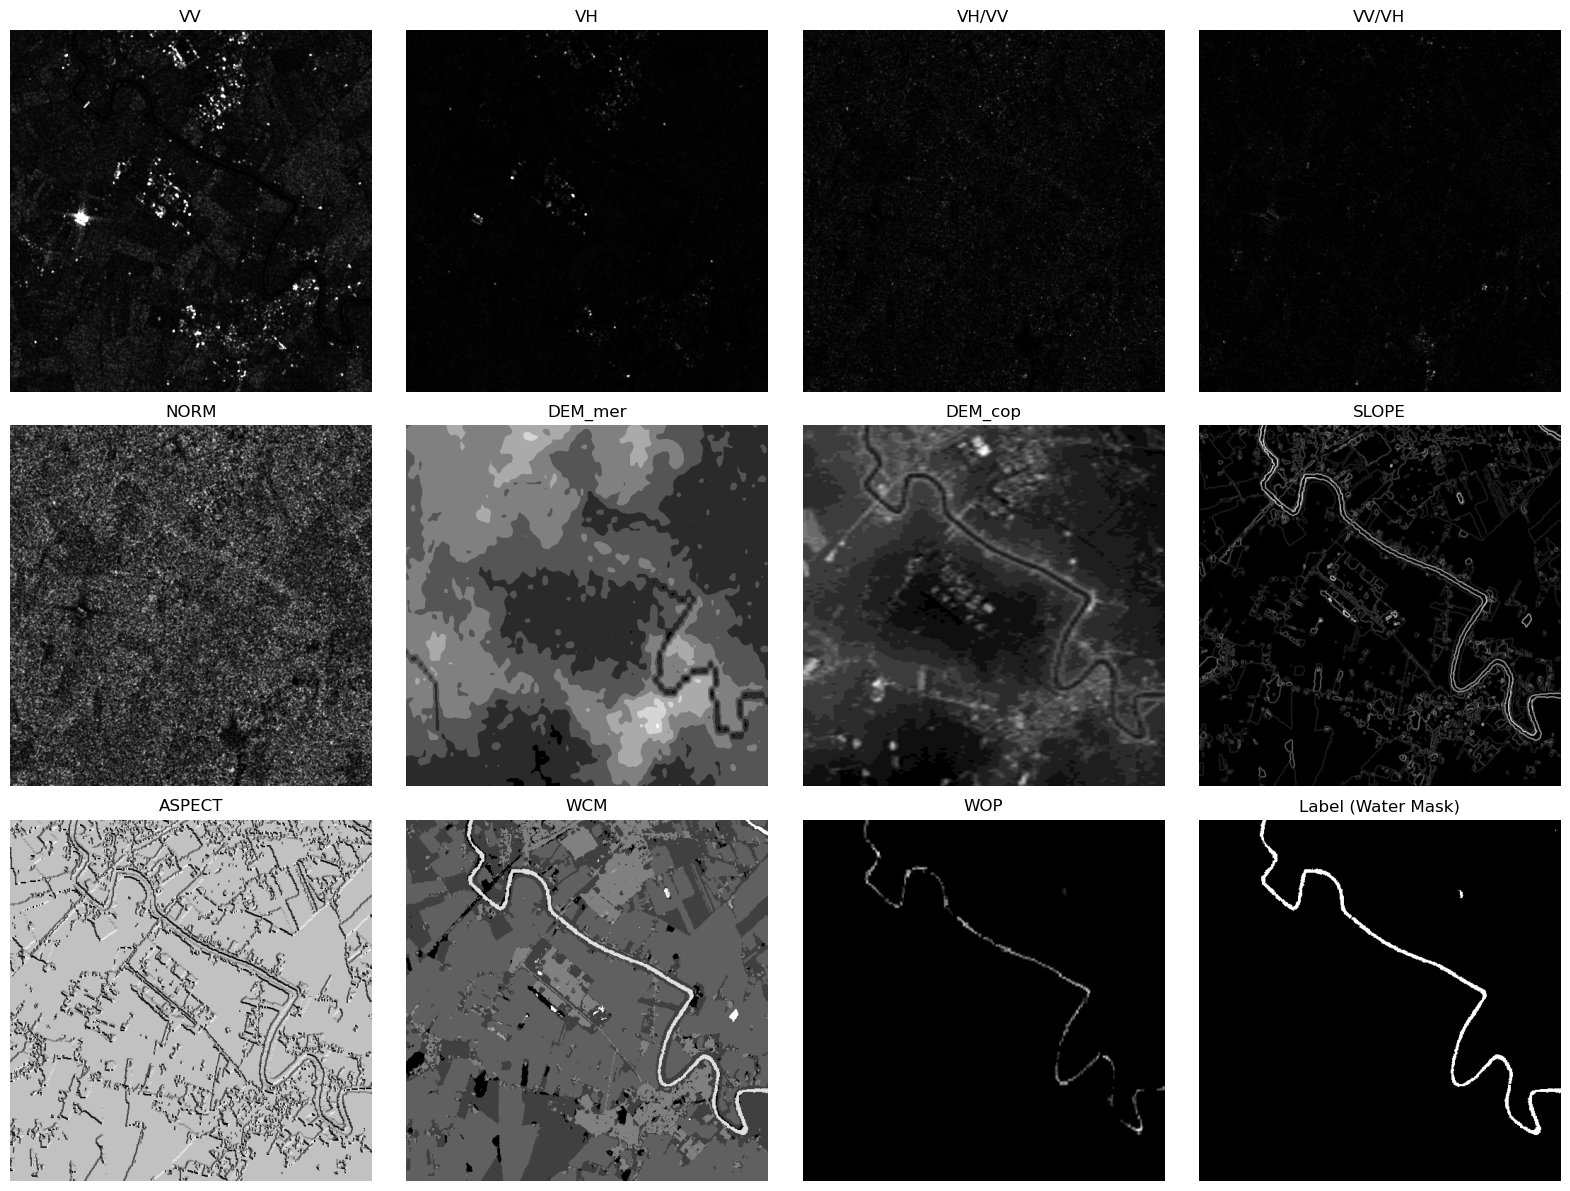

In [ ]:
# # Features visualization
# image_dir = 'C:/Users/maria/Documents/01_Teledeteccion/04_AEI/00_Practicas/Trabajo/Inputs/train/images'
# label_dir = 'C:/Users/maria/Documents/01_Teledeteccion/04_AEI/00_Practicas/Trabajo/Inputs/train/labels' 

# # Select the number of images to be processed
# n = int(input("Select image number (value between 0 y 1630): "))

# vz.visualize_features(n, image_dir,label_dir)

In [226]:
X.describe().T

count         mean          std  min         25%          50%  \
VV       4194304.0  1829.822510  2610.206543  0.0  803.000000  1286.000000   
VH       4194304.0   394.023010   622.664001  0.0  185.000000   300.000000   
VH_VV    4194203.0          inf          NaN  0.0    0.137313     0.233616   
VV_VH    4194203.0          inf          NaN  0.0    2.572438     4.280528   
NORM     4194203.0    -0.576090     0.245788 -1.0   -0.758530    -0.621250   
DEM_mer  4194304.0   144.896194   363.861938  1.0   24.000000    43.000000   
DEM_cop  4194304.0   146.053284   365.861816  0.0   24.000000    43.000000   
SLOPE    4194304.0   264.009338   494.662659  0.0    0.000000     0.000000   
ASPECT   4194304.0   239.548325    73.432137  0.0  270.000000   270.000000   
WCM      4194304.0    30.978273    14.414845  0.0   10.000000    30.000000   
WOP      4194304.0     0.338017     4.764662  0.0    0.000000     0.000000   

                 75%           max  
VV       2021.000000  3.276500e+04  
VH        467.000000  3.276500e+04  
VH_VV       0.388736           inf  
VV_VH       7.282609           inf  
NORM       -0.440158  1.000000e+00  
DEM_mer    82.000000  2.304000e+03  
DEM_cop    84.000000  2.318000e+03  
SLOPE     353.553406  4.472136e+03  
ASPECT    270.000000  3.575104e+02  
WCM        40.000000  1.000000e+02  
WOP         0.000000  1.030000e+02

In [227]:
# Percentage of NaN values per feature
nan_percent = (X.isna().sum() / len(X)) * 100
nan_percent = nan_percent.sort_values(ascending=False)  

nan_percent

VH_VV      0.002408
VV_VH      0.002408
NORM       0.002408
VV         0.000000
VH         0.000000
DEM_mer    0.000000
DEM_cop    0.000000
SLOPE      0.000000
ASPECT     0.000000
WCM        0.000000
WOP        0.000000
dtype: float64

***Primeras conclusiones***:

- El DEM de Meris presenta valores -9999 que se corresponden con valores No data

- El DEM de Copernicus presenta valores negativos, que no tienen sentido físico, hay que eliminarlos o substituirlos (imputación con nuevos valores)

- Se generan valores 'inf' y NaN en los ratios VH/VV, VV/VH y VH-VV/VH+VV por la presencia de valores 0 en VV y VH. Se eliminarán estos valores

- Variable WCM tiene valores 0.0 que se corresponden con valores No Data, conforme información del dataset

- Variable WOP tiene valores >100 que se corresponden con valores No Data, conforme información del dataset

- Teniendo en cuenta la capacidad computacional, se recomienda trabajar con subsets de datos

In [4]:
# Load the subsample (1% of the total images)
X_path = os.path.join(data_path, 'X_0.01.pkl') 
y_path = os.path.join(data_path, 'y_0.01.pkl')
X= pd.read_pickle(X_path)
y = pd.read_pickle(y_path)

In [73]:
X.shape

(4194304, 11)

<a id='clean'></a>
#### 2.2 Data cleaning



##### 2.2.1 Remove inf and NaN values

In [5]:
# Remove NaN and infinite values
X_clean = X.replace([np.inf, -np.inf], np.nan).dropna().reset_index(drop=True)
y_clean = y.loc[X_clean.index].reset_index(drop=True)

##### 2.2.2 Remove No Data values (WCM & WOP)

In [6]:
# Drop rows with No Data Values for WCM and WOP columns
X_clean, y_clean = dP.drop_NoData_rows(X_clean, y_clean)

In [7]:
print(X_clean.shape)
print(y_clean.shape)

(4182615, 11)
(4182615,)


In [8]:
X_clean.describe().T # check the cleaning

count         mean          std        min         25%  \
VV       4182615.0  1834.464966  2612.614258   1.000000  807.000000   
VH       4182615.0   395.121613   623.239502   1.000000  186.000000   
VH_VV    4182615.0     0.312143     0.327342   0.000305    0.138018   
VV_VH    4182615.0     6.439882    11.100072   0.010526    2.568773   
NORM     4182615.0    -0.575052     0.244761  -0.999390   -0.757441   
DEM_mer  4182615.0   145.258072   364.333282   1.000000   24.000000   
DEM_cop  4182615.0   146.421478   366.310822   0.000000   24.000000   
SLOPE    4182615.0   264.552399   494.659607   0.000000    0.000000   
ASPECT   4182615.0   239.482803    73.462471   0.000000  270.000000   
WCM      4182615.0    30.919586    14.355376  10.000000   10.000000   
WOP      4182615.0     0.293257     4.380037   0.000000    0.000000   

                 50%          75%           max  
VV       1289.000000  2024.000000  32765.000000  
VH        301.000000   468.000000  32765.000000  
VH_VV       0.234195     0.389291     95.000000  
VV_VH       4.269953     7.245410   3276.500000  
NORM       -0.620490    -0.439583      0.979167  
DEM_mer    44.000000    82.000000   2304.000000  
DEM_cop    43.000000    84.000000   2318.000000  
SLOPE       0.000000   395.284698   4472.135742  
ASPECT    270.000000   270.000000    357.510437  
WCM        30.000000    40.000000    100.000000  
WOP         0.000000     0.000000    100.000000

### 3. Train-test split

In [9]:
#Seleccionamos train y test
X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, test_size=0.2, random_state= 43, stratify=y_clean) 

print(X_train.shape)
print(y_train.shape)

(3346092, 11)
(3346092,)


### 4. Variable target

In [236]:
y_train.value_counts(normalize=True)*100

Labels
0.0    95.695815
1.0     4.304185
Name: proportion, dtype: float64

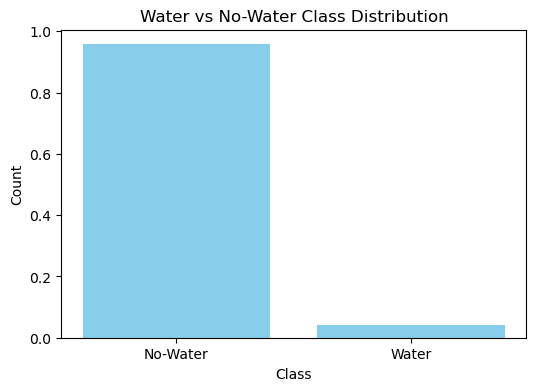

In [237]:
# Calculate frequency of each class
label_freq = y_train.value_counts(normalize=True).sort_index()
# Create mapping
label_names = {0.0: 'No-Water', 1.0: 'Water'}
label_names_list = [label_names[val] for val in label_freq.index]

# Plot
plt.figure(figsize=(6,4))
plt.bar(label_names_list, label_freq.values, color='skyblue')
plt.title('Water vs No-Water Class Distribution')
plt.ylabel('Count')
plt.xlabel('Class')
plt.show()


Las clases están muy desbalanceadas, siendo la clase target o positiva (water) la de menor proporción

### 5. Undersampling

In [79]:
# Undersampling
datos = X_train
datos['Labels'] = y_train

#Extraemos los pixeles con agua y los sin agua
agua = datos[datos['Labels']==1]
no_agua = datos[datos['Labels']==0]

#Cogemos dos datasets iguales
agua_sam = agua.sample(n = len(agua))
no_agua_sam = no_agua.sample(n = len(agua))

#Concatenamos los datasets
datos= pd.concat([agua_sam, no_agua_sam], axis=0,ignore_index=True)

# Mezclamos los datos (shuffle)
# datos = datos.sample(frac=1, random_state=42).reset_index(drop=True)

X_train_bal = datos.drop('Labels',axis='columns')
y_train_bal = datos['Labels']

In [80]:
y_train_bal.value_counts(normalize=True)

Labels
1.0    0.5
0.0    0.5
Name: proportion, dtype: float64

### 6. Features

#### 6.1 Univariate analysis

In [240]:
X_train_bal.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288044 entries, 0 to 288043
Data columns (total 11 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   VV       288044 non-null  float32
 1   VH       288044 non-null  float32
 2   VH_VV    288044 non-null  float32
 3   VV_VH    288044 non-null  float32
 4   NORM     288044 non-null  float32
 5   DEM_mer  288044 non-null  float32
 6   DEM_cop  288044 non-null  float32
 7   SLOPE    288044 non-null  float32
 8   ASPECT   288044 non-null  float32
 9   WCM      288044 non-null  float32
 10  WOP      288044 non-null  float32
dtypes: float32(11)
memory usage: 12.1 MB


In [241]:
X_train_bal.describe().T

count         mean          std        min         25%  \
VV       288044.0  1542.920166  2181.811523   1.000000  664.000000   
VH       288044.0   326.558685   532.757263   1.000000  139.000000   
VH_VV    288044.0     0.310084     0.496881   0.000305    0.127551   
VV_VH    288044.0     7.360521    17.559738   0.011494    2.638506   
NORM     288044.0    -0.586389     0.252824  -0.999390   -0.773756   
DEM_mer  288044.0    89.372398   275.438171   1.000000   15.000000   
DEM_cop  288044.0    89.984848   277.035065   0.000000   16.000000   
SLOPE    288044.0   290.087738   588.031372   0.000000    0.000000   
ASPECT   288044.0   239.723465    73.175919   0.000000  270.000000   
WCM      288044.0    33.410938    16.538918  10.000000   30.000000   
WOP      288044.0     1.943977    11.255442   0.000000    0.000000   

                 50%          75%           max  
VV       1137.000000  1806.000000  32765.000000  
VH        252.000000   407.000000  32765.000000  
VH_VV       0.223046     0.379002     87.000000  
VV_VH       4.483389     7.840027   3276.500000  
NORM       -0.635262    -0.450324      0.977273  
DEM_mer    31.000000    58.000000   2299.000000  
DEM_cop    30.000000    57.000000   2315.000000  
SLOPE       0.000000   353.553406   4304.793945  
ASPECT    270.000000   270.000000    357.510437  
WCM        40.000000    40.000000    100.000000  
WOP         0.000000     0.000000    100.000000

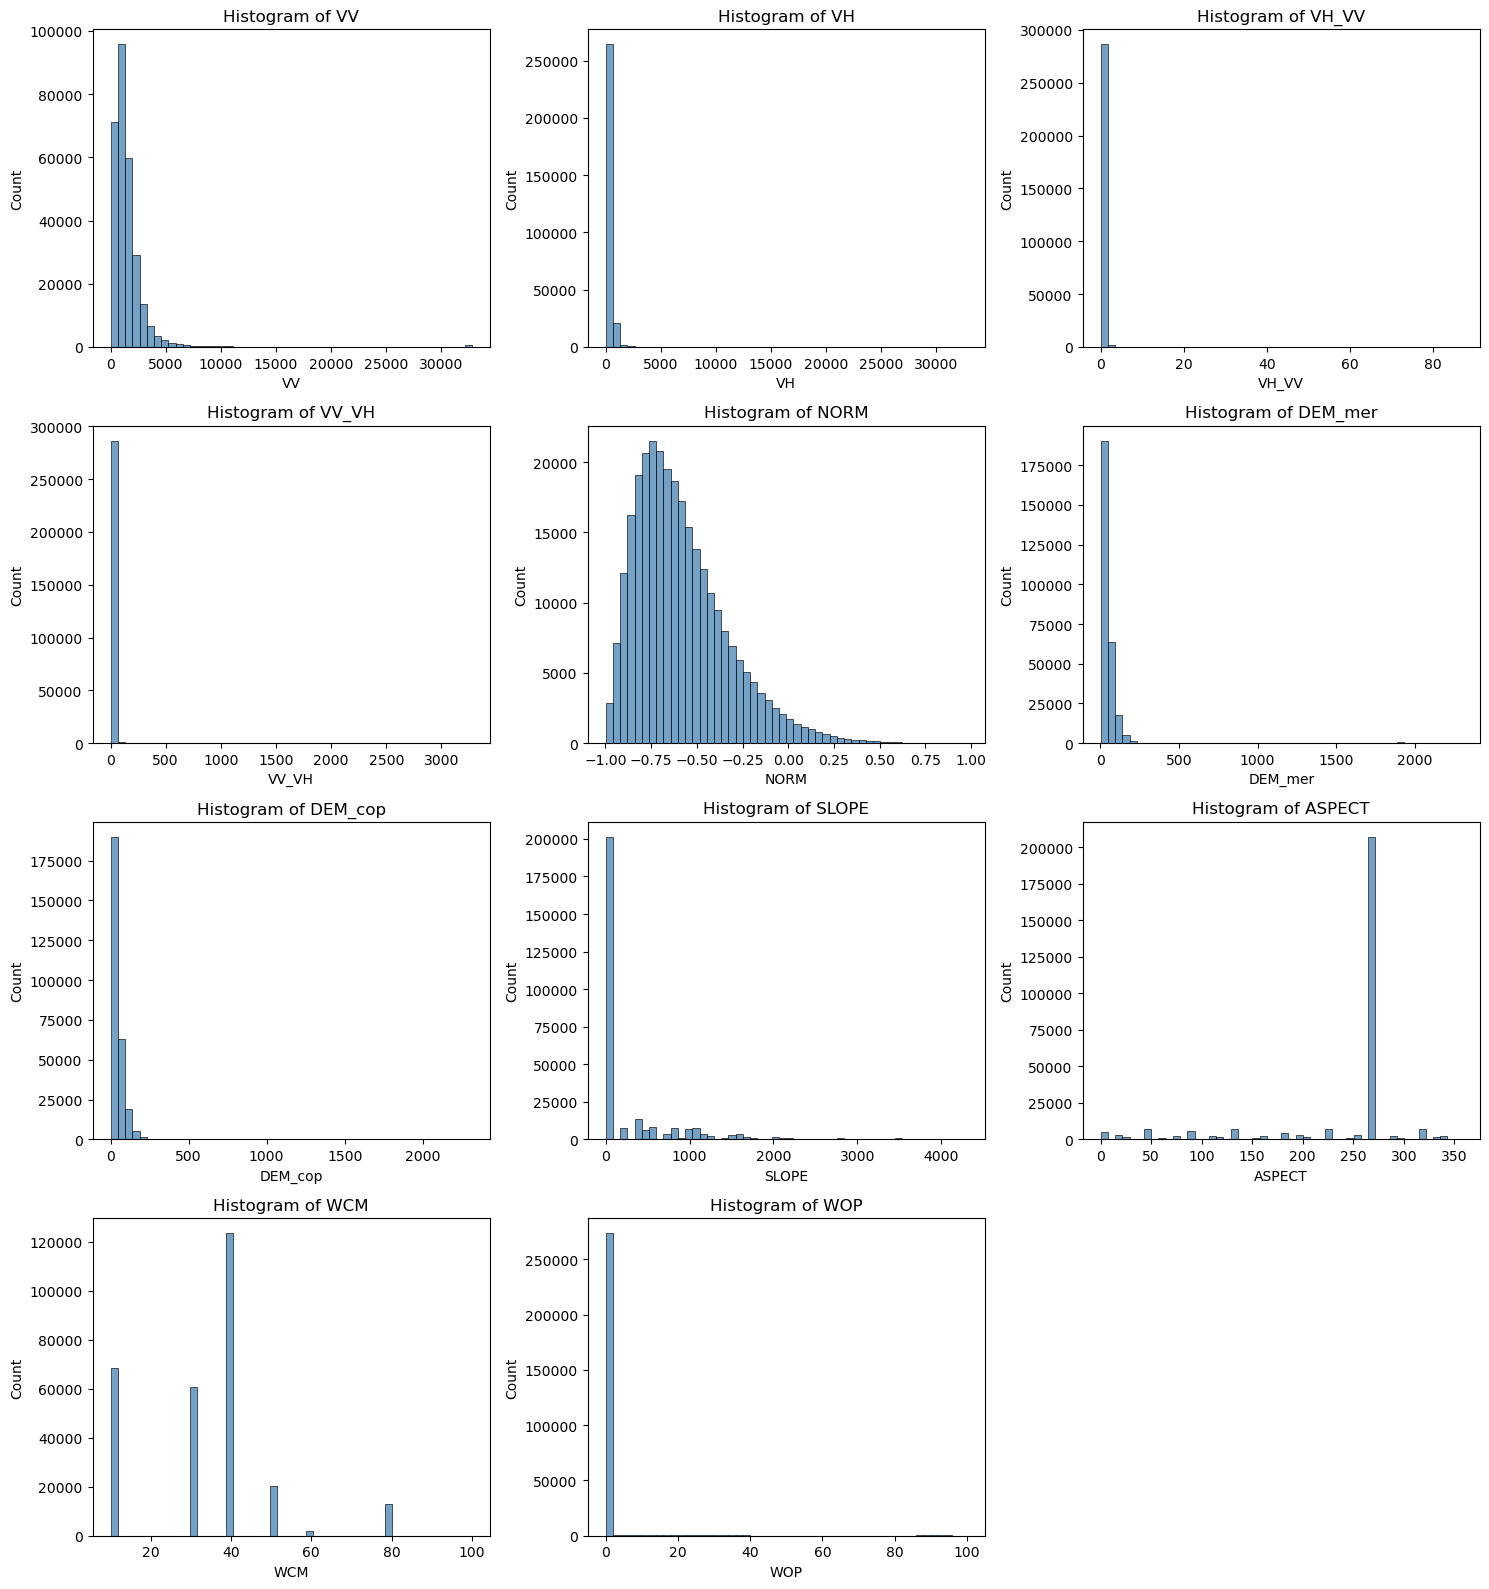

In [242]:
# Feature histograms
vz.plot_feature_histograms(X_train_bal)


##### **Conclusiones & Próximos pasos con las features**

1. Seleccionar un DEM y eliminar los valores negativos

2. ***Variables categóricas multiclase***: WCM & aspect

    - La feature WCM es categórica, con la siguiente correspondencia de clases. El valor 0 no es un valor válido: missing data, pixels masked due to cloud, shadows or quality issues


<style>
table {
  font-size: 14px;}
</style>
| Class Code | Class Name               | Description                                 |
|------------|--------------------------|---------------------------------------------|
| 10         | Tree cover               | Natural & planted forest and tree crops     |
| 20         | Shrubland                | Woody vegetation < 5m                       |
| 30         | Grassland                | Natural grasslands and managed pastures     |
| 40         | Cropland                 | Cultivated areas, incl. rice & mosaics      |
| 50         | Built-up                 | Urban areas, buildings, roads               |
| 60         | Bare / sparse vegetation | Desert, rock, salt flats, very sparse veg   |
| 70         | Snow and ice             | Permanent snow, glaciers                    |
| 80         | Permanent water bodies   | Lakes, rivers, reservoirs, etc.             |
| 90         | Herbaceous wetland       | Swamps, marshes with herbaceous plants      |
| 95         | Mangroves                | Coastal, saline-tolerant forest/shrubs      |
| 100        | Moss and lichen          | Tundra, high-latitude moss/lichen areas     |
  

 -  La variable aspect indica la orientación de la pendiente. Se va a binnear y tratar como una categórica. El valor 270 de aspecto se corresponde con un valor dummy asignado por richdem a las superficies planas (librería con la que se ha calculado pendiente y orientación/aspect)


<style>
table {
  font-size: 14px;}
</style>
| Class        | Angle Range (°)         | Label |
|--------------|--------------------------|-------|
| Flat         | = 270                    | Flat  |
| North        | 337.5 – 360 and 0 – 22.5 | N     |
| North-East   | 22.5 – 67.5              | NE    |
| East         | 67.5 – 112.5             | E     |
| South-East   | 112.5 – 157.5            | SE    |
| South        | 157.5 – 202.5            | S     |
| South-West   | 202.5 – 247.5            | SW    |
| West         | 247.5 – 269.9 and 270.1 – 292.5 | W     |
| North-West   | 292.5 – 337.5            | NW    |


3. ***Variables numéricas***: VV, VH, VH_VV, VV_VH, NORM, DEM_cop, SLOPE, WOP		

    - Todas las variables presentan una distribución sesgada hacia la derecha
    
    - El valor predominante en WOP es 0, que significa 0% de probabilidad de ocurrencia de agua. Distribución similar a la de la variable target

    - Ambos DEM proporcionana una información muy similar por lo que se podría prescindir de uno de ellos

    - Predominan superficies de baja cota (valores DEM próximos a 0) y sin pendiente (valores de pendiente próximos a 0)

    - Los valores de pendientes elevados, corresponden con acantilados o edificios (ej: un valor de 5000 equivale a unos 88º, lo que se corresponde con una pared vertical)

#### 6.2 Features categóricas: tratamiento y análisis bivariante con el target

##### 6.2.1 Feature engineering: categorical derived features

In [243]:
# Feature aspect binning transformation
X_train_bal = dP.bin_aspect_to_direction(X_train_bal)

In [244]:
X_train_bal.ORIENT.value_counts()

ORIENT
Flat    206983
E        11143
SW       10811
N        10738
SE       10693
NW       10685
S        10629
NE       10541
W         5821
Name: count, dtype: int64

In [245]:
X_train_bal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288044 entries, 0 to 288043
Data columns (total 12 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   VV       288044 non-null  float32
 1   VH       288044 non-null  float32
 2   VH_VV    288044 non-null  float32
 3   VV_VH    288044 non-null  float32
 4   NORM     288044 non-null  float32
 5   DEM_mer  288044 non-null  float32
 6   DEM_cop  288044 non-null  float32
 7   SLOPE    288044 non-null  float32
 8   ASPECT   288044 non-null  float32
 9   WCM      288044 non-null  float32
 10  WOP      288044 non-null  float32
 11  ORIENT   288044 non-null  object 
dtypes: float32(11), object(1)
memory usage: 14.3+ MB


In [246]:
# Feature WMC
X_train_bal = dP.map_wcm_classes(X_train_bal)

X_train_bal.WCM_LABEL.value_counts(normalize=True)*100

WCM_LABEL
Cropland                    42.866368
Tree cover                  23.776576
Grassland                   21.056505
Built-up                     7.104817
Permanent water bodies       4.475011
Bare / sparse vegetation     0.703712
Herbaceous wetland           0.015970
Moss and lichen              0.000694
Shrubland                    0.000347
Name: proportion, dtype: float64

In [247]:
X_train_bal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288044 entries, 0 to 288043
Data columns (total 13 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   VV         288044 non-null  float32
 1   VH         288044 non-null  float32
 2   VH_VV      288044 non-null  float32
 3   VV_VH      288044 non-null  float32
 4   NORM       288044 non-null  float32
 5   DEM_mer    288044 non-null  float32
 6   DEM_cop    288044 non-null  float32
 7   SLOPE      288044 non-null  float32
 8   ASPECT     288044 non-null  float32
 9   WCM        288044 non-null  float32
 10  WOP        288044 non-null  float32
 11  ORIENT     288044 non-null  object 
 12  WCM_LABEL  288044 non-null  object 
dtypes: float32(11), object(2)
memory usage: 16.5+ MB


##### 6.2.2 Viz

In [248]:
# Create a df for plotting and statistical analysis
y_labeled = y_train_bal.map({0: 'No-Water', 1: 'Water'})
df = pd.concat([
    X_train_bal,
    y_labeled.rename('Label'),        # categorical
    y_train_bal.rename('Label_num')       # numeric
], axis=1)

In [249]:
df

VV     VH     VH_VV      VV_VH      NORM  DEM_mer  DEM_cop  \
0       2064.0  345.0  0.167151   5.982609 -0.713574     20.0     18.0   
1       1063.0   97.0  0.091251  10.958763 -0.832759     15.0     17.0   
2        788.0  223.0  0.282995   3.533632 -0.558853     13.0     14.0   
3       2753.0  783.0  0.284417   3.515964 -0.557127     48.0     49.0   
4        626.0   73.0  0.116613   8.575342 -0.791130     35.0     34.0   
...        ...    ...       ...        ...       ...      ...      ...   
288039   371.0   93.0  0.250674   3.989247 -0.599138     13.0     14.0   
288040  1124.0  319.0  0.283808   3.523511 -0.557866     30.0     29.0   
288041  1343.0  526.0  0.391660   2.553232 -0.437132     31.0     31.0   
288042  2099.0   80.0  0.038113  26.237499 -0.926572     19.0     20.0   
288043   920.0  557.0  0.605435   1.651706 -0.245768     66.0     66.0   

              SLOPE      ASPECT   WCM  WOP ORIENT   WCM_LABEL     Label  \
0          0.000000  270.000000  40.0  0.0   Flat    Cropland     Water   
1          0.000000  270.000000  40.0  0.0   Flat    Cropland     Water   
2          0.000000  270.000000  40.0  0.0   Flat    Cropland     Water   
3          0.000000  270.000000  10.0  0.0   Flat  Tree cover     Water   
4          0.000000  270.000000  40.0  0.0   Flat    Cropland     Water   
...             ...         ...   ...  ...    ...         ...       ...   
288039  1677.051025   26.565052  40.0  0.0     NE    Cropland  No-Water   
288040   559.016968  243.434952  30.0  0.0     SW   Grassland  No-Water   
288041     0.000000  270.000000  40.0  0.0   Flat    Cropland  No-Water   
288042     0.000000  270.000000  30.0  0.0   Flat   Grassland  No-Water   
288043     0.000000  270.000000  50.0  0.0   Flat    Built-up  No-Water   

        Label_num  
0             1.0  
1             1.0  
2             1.0  
3             1.0  
4             1.0  
...           ...  
288039        0.0  
288040        0.0  
288041        0.0  
288042        0.0  
288043        0.0  

[288044 rows x 15 columns]

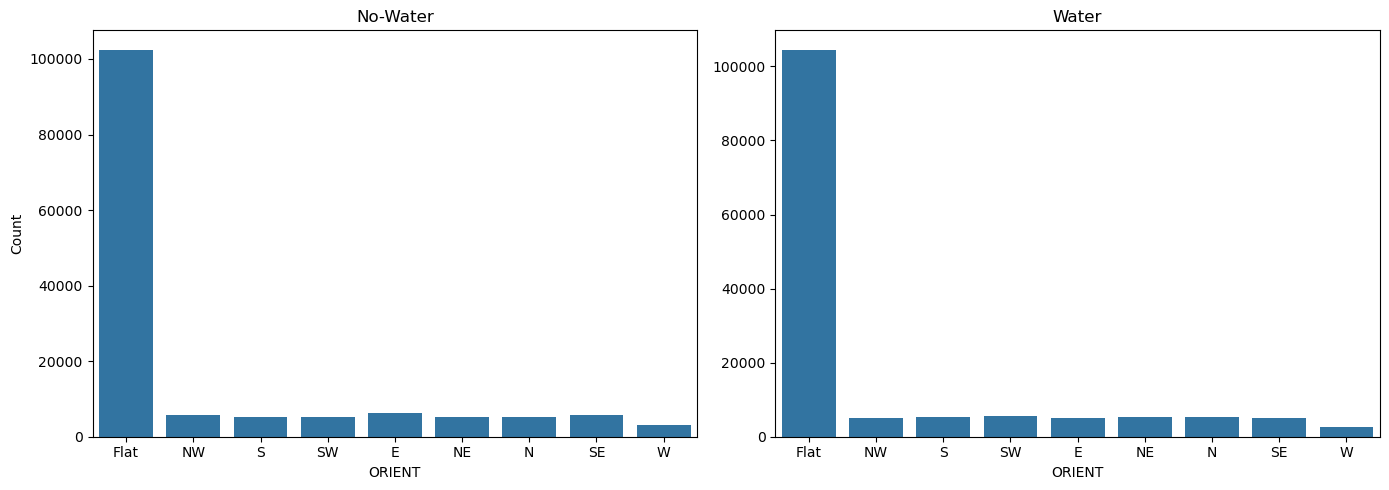

In [250]:
# Create figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=False)
orient_order = df['ORIENT'].unique().tolist()  # or sort manually if preferred

# Plot No-Water
sns.countplot(x='ORIENT', data=df[df['Label'] == 'No-Water'], ax=axes[0], order=orient_order)
axes[0].set_title('No-Water')
axes[0].set_xlabel('ORIENT')
axes[0].set_ylabel('Count')

# Plot Water
sns.countplot(x='ORIENT', data=df[df['Label'] == 'Water'], ax=axes[1], order=orient_order)
axes[1].set_title('Water')
axes[1].set_xlabel('ORIENT')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

Las distribuciones de ORIENT son similares tanto en zonas inundadas como no inundadas por lo que no parece una feature muy informativa

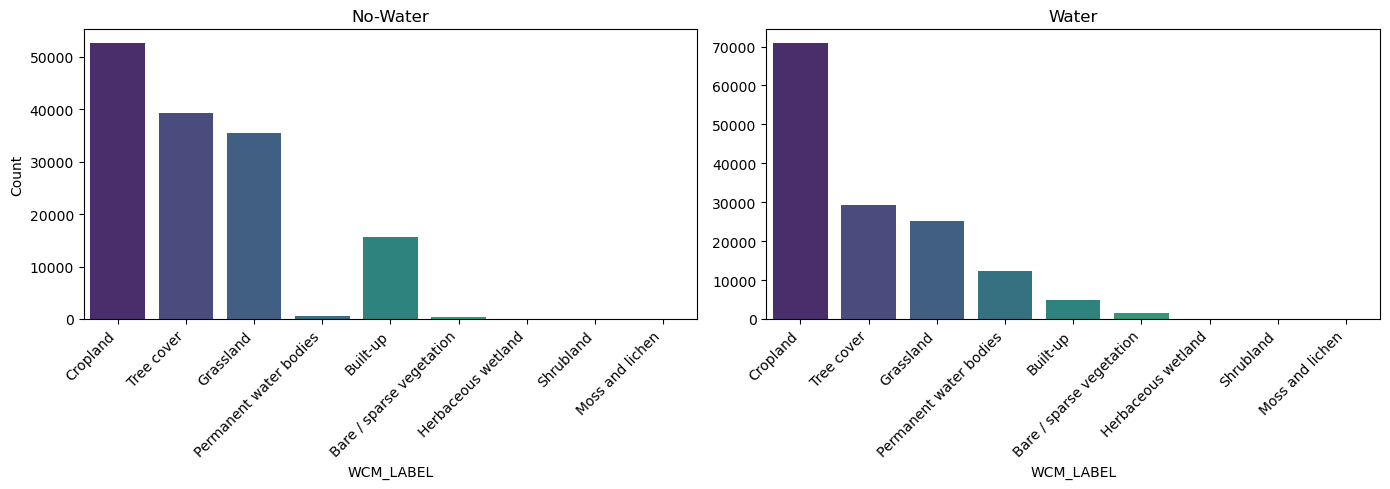

In [251]:
# Create figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=False)
wcm_order = df['WCM_LABEL'].dropna().unique().tolist()  # or sort manually if preferred

# Plot No-Water
sns.countplot(x='WCM_LABEL', data=df[df['Label'] == 'No-Water'], ax=axes[0], order=wcm_order,palette='viridis')
axes[0].set_title('No-Water')
axes[0].set_xlabel('WCM_LABEL')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
# axes[0].tick_params(axis='x', rotation=45)

# Plot Water
sns.countplot(x='WCM_LABEL', data=df[df['Label'] == 'Water'], ax=axes[1], order=wcm_order, palette='viridis')
axes[1].set_title('Water')
axes[1].set_xlabel('WCM_LABEL')
axes[1].set_ylabel('')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
# axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

##### 6.2.3 Statistical test

In [252]:
# Chi-squared test for ORIENT
contingency_orient = pd.crosstab(df['ORIENT'], df['Label_num'])
chi2_orient, p_orient, _, expected_orient = chi2_contingency(contingency_orient)
expected_orient_df = pd.DataFrame(expected_orient, 
                                  index=contingency_orient.index, 
                                  columns=contingency_orient.columns)

# Chi-squared test for WCM_LABEL
contingency_wcm = pd.crosstab(df['WCM_LABEL'], df['Label_num'])
chi2_wcm, p_wcm, _, expected_wcm = chi2_contingency(contingency_wcm)
expected_wcm_df = pd.DataFrame(expected_wcm, 
                               index=contingency_wcm.index, 
                               columns=contingency_wcm.columns)

# Results
print(f"Chi-squared test for ORIENT vs Target:")
print(f"  Chi2 = {chi2_orient:.2f}, p-value = {p_orient:.4f}")

print(f"\nChi-squared test for WCM_LABEL vs Target:")
print(f"  Chi2 = {chi2_wcm:.2f}, p-value = {p_wcm:.4f}")

Chi-squared test for ORIENT vs Target:
  Chi2 = 291.43, p-value = 0.0000

Chi-squared test for WCM_LABEL vs Target:
  Chi2 = 23220.60, p-value = 0.0000


A very low p-value (typically < 0.05) indicates that the variables are not independent, i.e., there is a statistically significant association.

In [253]:
# Results
print("Observed Frequencies (ORIENT):")
contingency_orient

Observed Frequencies (ORIENT):


Label_num     0.0     1.0
ORIENT                   
E            6210    4933
Flat       102461  104522
N            5332    5406
NE           5220    5321
NW           5659    5026
S            5194    5435
SE           5635    5058
SW           5187    5624
W            3124    2697

In [254]:
print("Observed Frequencies (WCM_LABEL):")
contingency_wcm

Observed Frequencies (WCM_LABEL):


Label_num                   0.0    1.0
WCM_LABEL                             
Bare / sparse vegetation    371   1656
Built-up                  15674   4791
Cropland                  52595  70879
Grassland                 35508  25144
Herbaceous wetland            4     42
Moss and lichen               2      0
Permanent water bodies      593  12297
Shrubland                     0      1
Tree cover                39275  29212

#### 6.3 Features numéricas: tratamiento y análisis bivariante con el target

##### 6.3.1 DEM negative values treatment

In [277]:
# Analysis of the negative values in the DEMs
DEM_meris_percent_negative = (X_train_bal['DEM_mer'] < 0).mean() * 100
print(f"Percentage of negative DEM_meris values: {DEM_meris_percent_negative:.2f}%")

DEM_cop_percent_negative = (X_train_bal['DEM_cop'] < 0).mean() * 100
print(f"Percentage of negative DEM_cop values: {DEM_cop_percent_negative:.2f}%")

Percentage of negative DEM_meris values: 0.00%
Percentage of negative DEM_cop values: 0.00%


In [278]:
# Replace negative values in DEM_cop with values from DEM_mer
X_train_bal['DEM_cop_filled'] = X_train_bal['DEM_cop'].where(X_train_bal['DEM_cop'] >= 0, X_train_bal['DEM_mer'])
X_train_bal['DEM_cop_filled'] = X_train_bal['DEM_cop_filled'].apply(lambda x: x if x >= 0 else 0)

In [279]:
DEM_cop_percent_negative = (X_train_bal['DEM_cop_filled'] < 0).mean() * 100
print(f"Percentage of negative DEM_cop_filled values: {DEM_cop_percent_negative:.2f}%")

Percentage of negative DEM_cop_filled values: 0.00%


In [280]:
X_train_bal

VV     VH     VH_VV      VV_VH      NORM  DEM_mer  DEM_cop  \
0       2064.0  345.0  0.167151   5.982609 -0.713574     20.0     18.0   
1       1063.0   97.0  0.091251  10.958763 -0.832759     15.0     17.0   
2        788.0  223.0  0.282995   3.533632 -0.558853     13.0     14.0   
3       2753.0  783.0  0.284417   3.515964 -0.557127     48.0     49.0   
4        626.0   73.0  0.116613   8.575342 -0.791130     35.0     34.0   
...        ...    ...       ...        ...       ...      ...      ...   
288039   371.0   93.0  0.250674   3.989247 -0.599138     13.0     14.0   
288040  1124.0  319.0  0.283808   3.523511 -0.557866     30.0     29.0   
288041  1343.0  526.0  0.391660   2.553232 -0.437132     31.0     31.0   
288042  2099.0   80.0  0.038113  26.237499 -0.926572     19.0     20.0   
288043   920.0  557.0  0.605435   1.651706 -0.245768     66.0     66.0   

              SLOPE      ASPECT   WCM  WOP ORIENT   WCM_LABEL  DEM_cop_filled  
0          0.000000  270.000000  40.0  0.0   Flat    Cropland            18.0  
1          0.000000  270.000000  40.0  0.0   Flat    Cropland            17.0  
2          0.000000  270.000000  40.0  0.0   Flat    Cropland            14.0  
3          0.000000  270.000000  10.0  0.0   Flat  Tree cover            49.0  
4          0.000000  270.000000  40.0  0.0   Flat    Cropland            34.0  
...             ...         ...   ...  ...    ...         ...             ...  
288039  1677.051025   26.565052  40.0  0.0     NE    Cropland            14.0  
288040   559.016968  243.434952  30.0  0.0     SW   Grassland            29.0  
288041     0.000000  270.000000  40.0  0.0   Flat    Cropland            31.0  
288042     0.000000  270.000000  30.0  0.0   Flat   Grassland            20.0  
288043     0.000000  270.000000  50.0  0.0   Flat    Built-up            66.0  

[288044 rows x 14 columns]

In [281]:
num_features = ['VV','VH','VH_VV','VV_VH','NORM','DEM_cop_filled','SLOPE','WOP'] # Just one DEM selected. Copernicus since the data is more updated

##### 6.3.2 Visual analysis

In [282]:
# Create a df for plotting and statistical analysis
df = pd.concat([
    X_train_bal,
    y_labeled.rename('Label'),        # categorical
    y_train_bal.rename('Label_num')       # numeric
], axis=1)

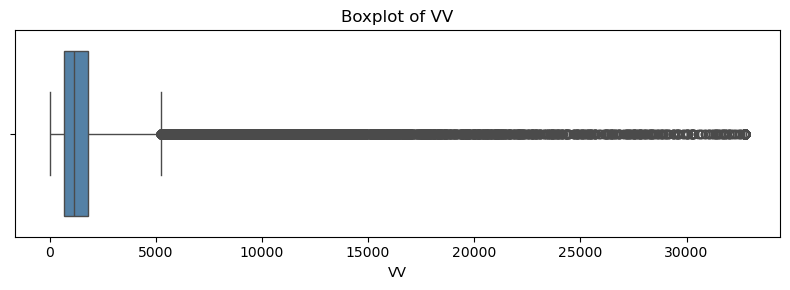

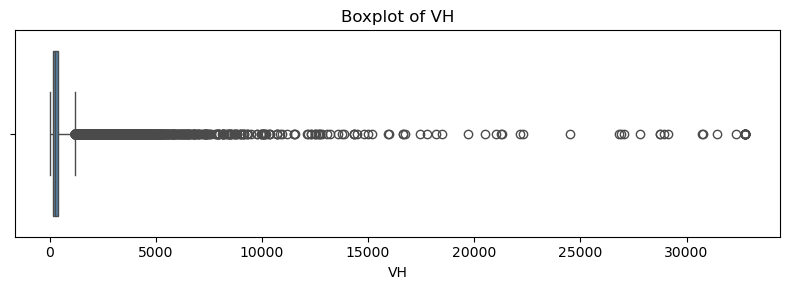

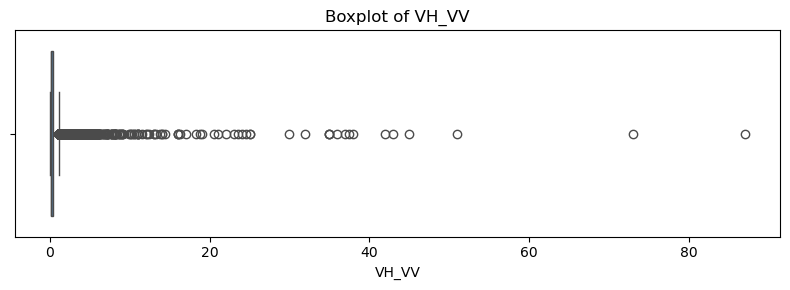

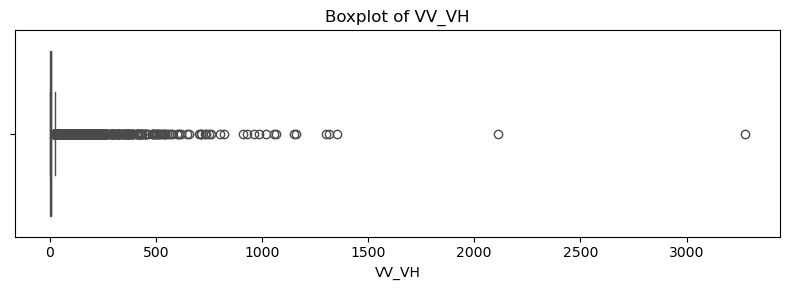

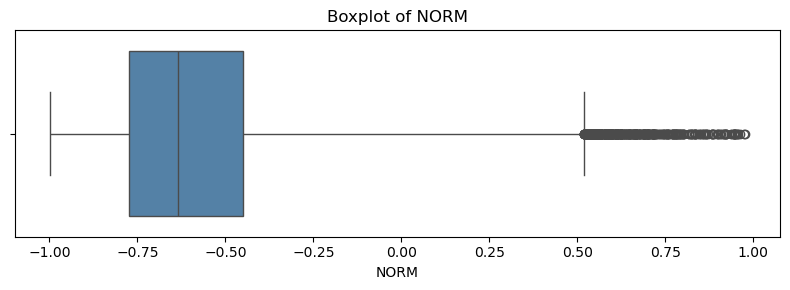

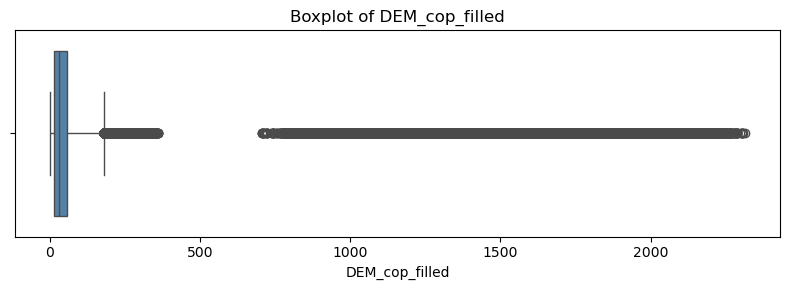

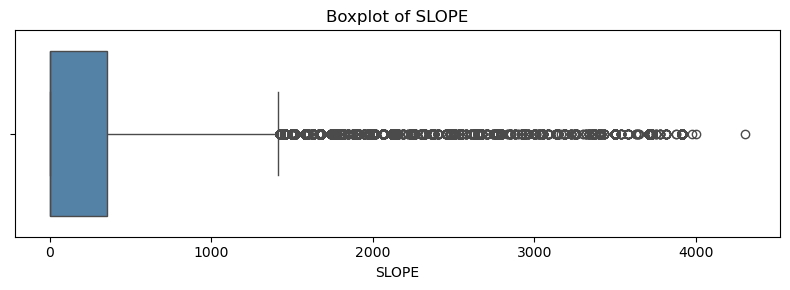

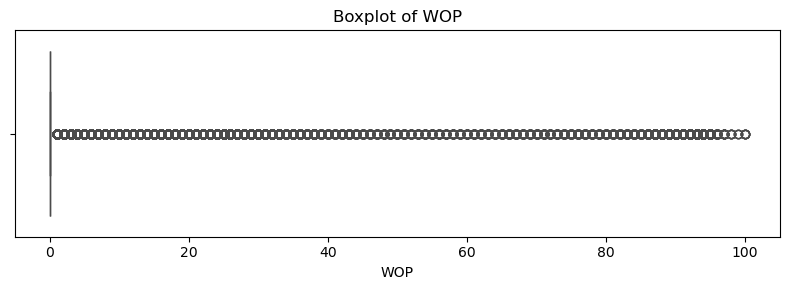

In [284]:
# Boxplot of the numerical features
# X_sample = X_train.sample(n=3000000, random_state=42) #10% of the data


# Plot one boxplot per feature
for col in num_features:
    plt.figure(figsize=(8, 3))
    # sns.boxplot(x=X_sample[col], color='steelblue',whis=3)
    sns.boxplot(x=X_train_bal[col], color='steelblue',whis=3)
    plt.title(f'Boxplot of {col}')
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()


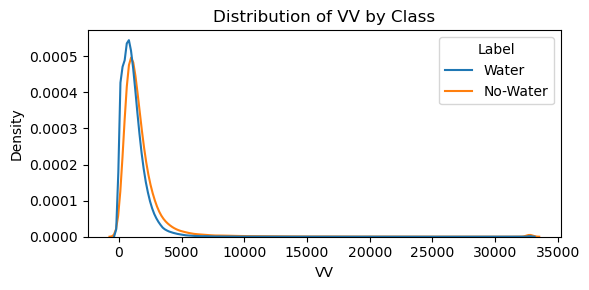

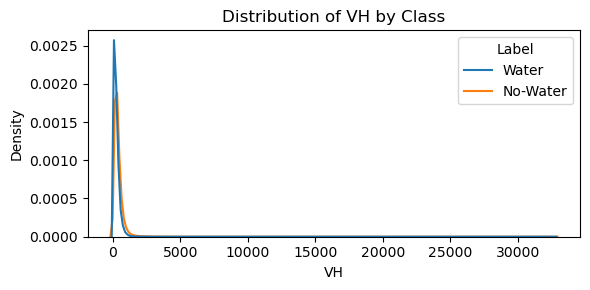

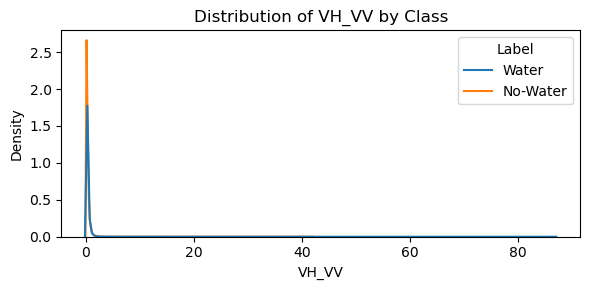

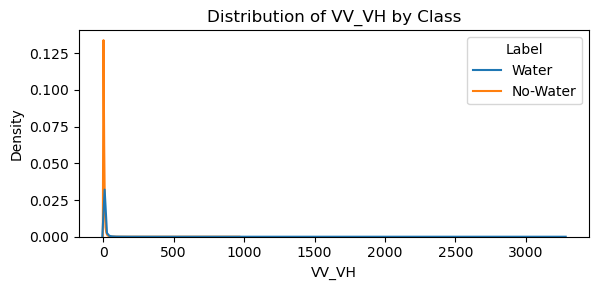

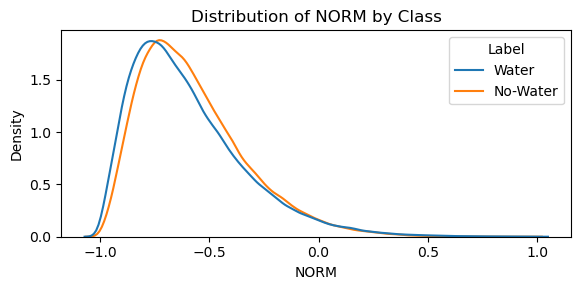

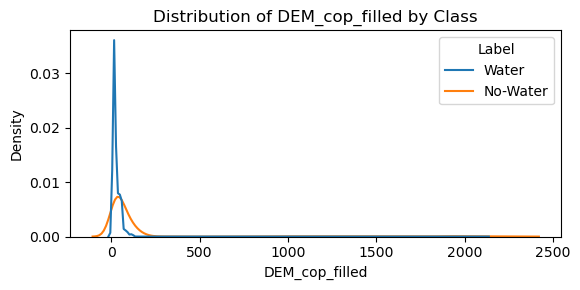

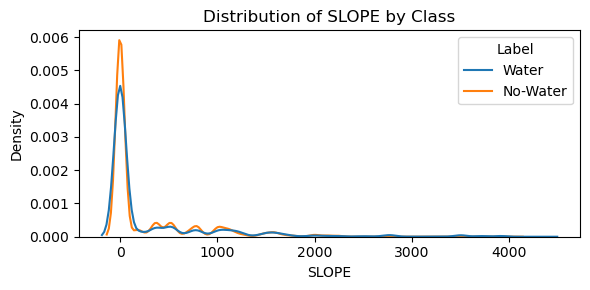

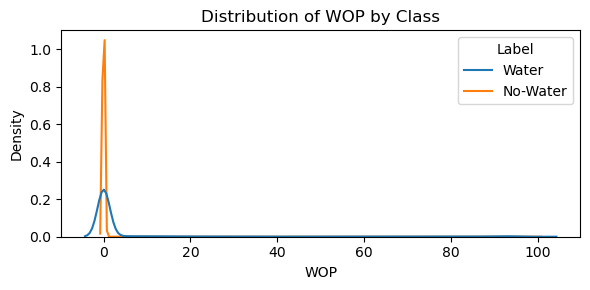

In [285]:
# X_sample = df.sample(n=50000, random_state=42) #10% of the data

# KDE plot of the numerical features
for col in num_features:
    plt.figure(figsize=(6, 3))
    sns.kdeplot(data=df, x=col, hue='Label', common_norm=False)
    plt.title(f'Distribution of {col} by Class')
    plt.tight_layout()
    plt.show()


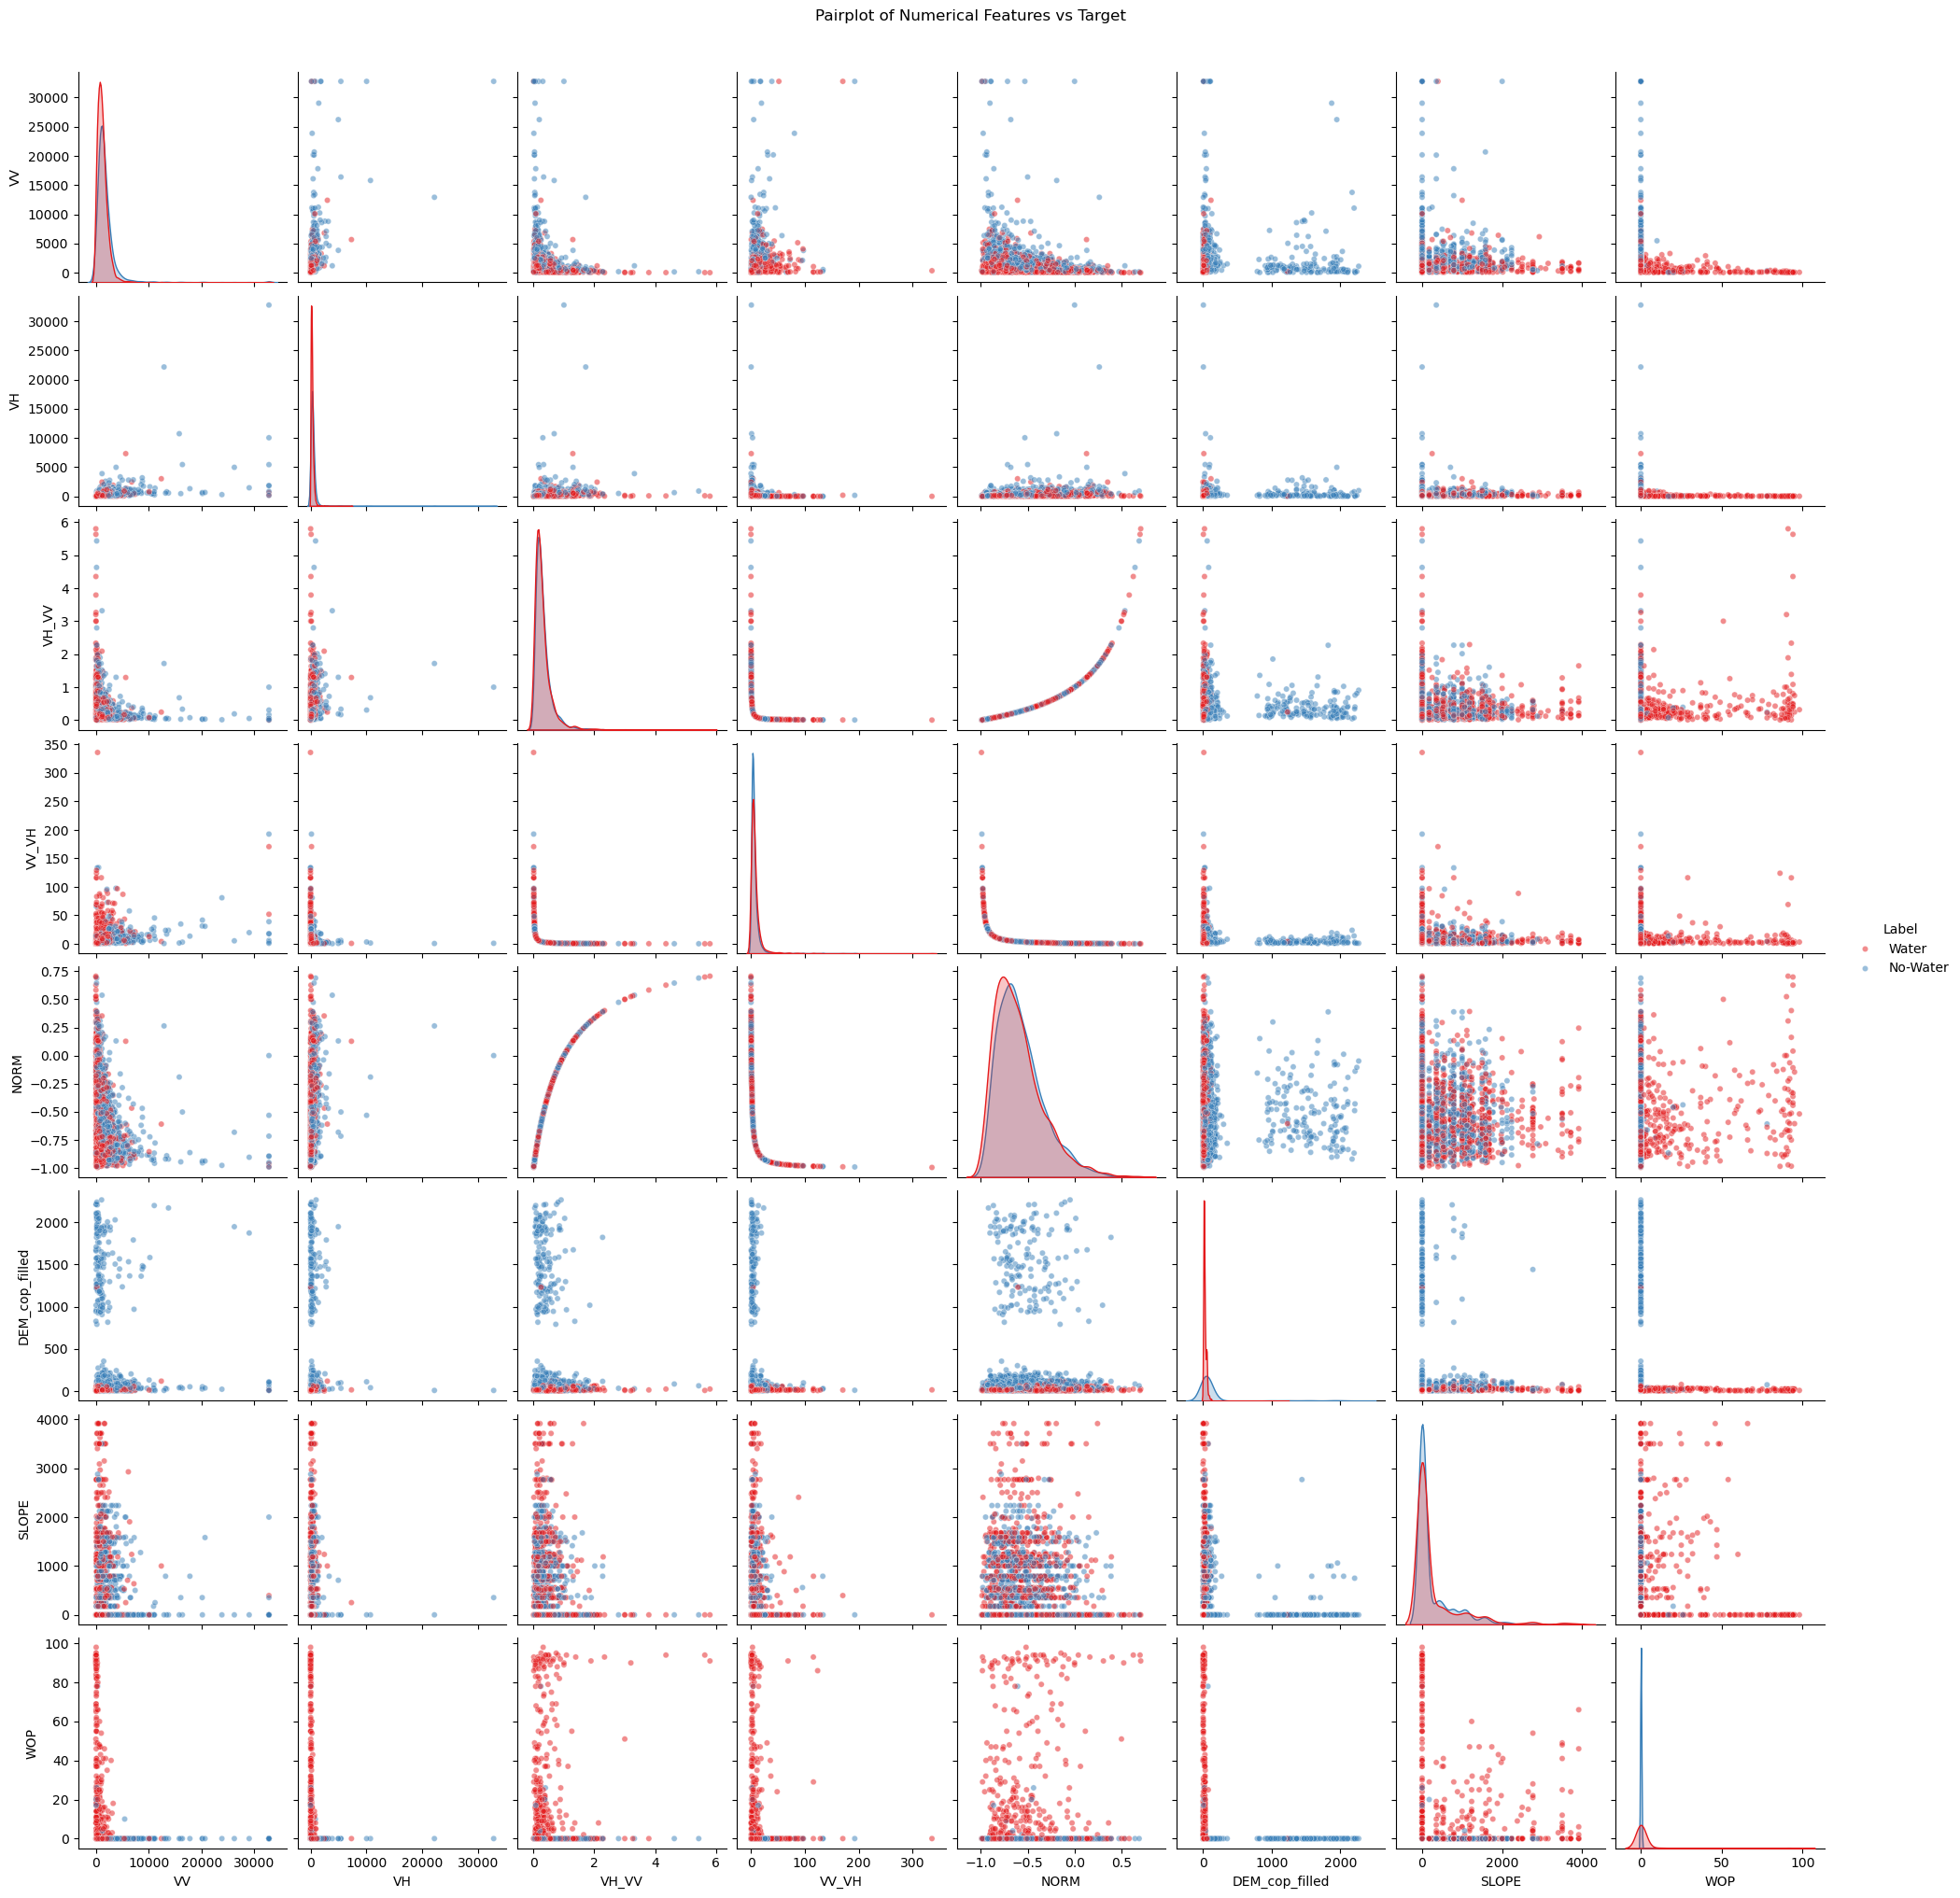

In [286]:
# Create a df for plotting
X_sample = df.sample(n=5000, random_state=42)

# Plot
sns.pairplot(
            data=X_sample[num_features + ['Label']],
             hue='Label',
             palette='Set1',
             plot_kws={'alpha': 0.5, 's': 20},  # s = marker size
             kind='scatter') 

plt.suptitle("Pairplot of Numerical Features vs Target", y=1.02)
plt.show()

##### 6.3.3 Statistical test

In [287]:
# Mann-Whitney U test for numerical features to test for significant differences between classes
results = [] #  DataFrame to store results

for col in num_features:
    group_0 = df[df['Label'] == 'No-Water'][col]
    group_1 = df[df['Label'] == 'Water'][col]
    
    stat, p = mannwhitneyu(group_0, group_1, alternative='two-sided')
    results.append({'Feature': col, 'U_statistic': stat, 'p_value': p})


u_test_results = pd.DataFrame(results).sort_values(by='p_value') # Results to DataFrame

print(u_test_results) # Show results

          Feature   U_statistic        p_value
0              VV  1.307374e+10   0.000000e+00
1              VH  1.387186e+10   0.000000e+00
5  DEM_cop_filled  1.529892e+10   0.000000e+00
7             WOP  9.360791e+09   0.000000e+00
2           VH_VV  1.117336e+10  4.908011e-283
3           VV_VH  9.568978e+09  4.908011e-283
4            NORM  1.117336e+10  4.908015e-283
6           SLOPE  1.043521e+10   4.057019e-04


##### 6.3.4 Transformations

In [288]:
# Log transformation of numerical features
X_train_bal_log = X_train_bal.copy()
X_train_bal_log[num_features]=X_train_bal_log[num_features].apply(lambda x: np.log1p(x))

# Standardize numerical features
scaler = StandardScaler()
X_train_bal_scaled = X_train_bal_log.copy()
X_train_bal_scaled[num_features] = scaler.fit_transform(X_train_bal_log[num_features])

In [289]:
X_train_bal_scaled.describe().T

count          mean         std        min         25%  \
VV              288044.0 -3.208794e-16    1.000002  -6.469421   -0.440239   
VH              288044.0 -1.397187e-16    1.000002  -4.868996   -0.468782   
VH_VV           288044.0 -1.963561e-17    1.000002  -1.303458   -0.671643   
VV_VH           288044.0  1.335024e-16    1.000002  -2.515195   -0.699254   
NORM            288044.0  2.723331e-17    1.000002  -8.951445   -0.560011   
DEM_mer         288044.0  8.937240e+01  275.438171   1.000000   15.000000   
DEM_cop         288044.0  8.998485e+01  277.035065   0.000000   16.000000   
SLOPE           288044.0 -7.770374e-17    1.000002  -0.651221   -0.651221   
ASPECT          288044.0  2.397235e+02   73.175919   0.000000  270.000000   
WCM             288044.0  3.341094e+01   16.538918  10.000000   30.000000   
WOP             288044.0  5.288788e-17    1.000002  -0.220053   -0.220053   
DEM_cop_filled  288044.0  5.130914e-17    1.000002  -3.416587   -0.697816   

                       50%         75%          max  
VV                0.117593    0.597710     3.606490  
VH                0.144097    0.639041     5.181545  
VH_VV            -0.242686    0.390573    22.319372  
VV_VH            -0.117438    0.560011     8.951471  
NORM              0.117438    0.699254     2.515195  
DEM_mer          31.000000   58.000000  2299.000000  
DEM_cop          30.000000   57.000000  2315.000000  
SLOPE            -0.651221    1.263679     2.078080  
ASPECT          270.000000  270.000000   357.510437  
WCM              40.000000   40.000000   100.000000  
WOP              -0.220053   -0.220053     6.001042  
DEM_cop_filled   -0.121309    0.479842     4.018061

### 7. Model selection with CV

#### 7.1 Pipelines to streamline the preprocessing

Get X_train & y_train without previous transformations and run undersampling. 

In [4]:
# Load X,y dataframes (10% of the total images)
X_path = os.path.join(data_path, 'X_0.01.pkl') 
y_path = os.path.join(data_path, 'y_0.01.pkl')
X= pd.read_pickle(X_path)
y = pd.read_pickle(y_path)

In case you want to work with a larger sample of data, run this sections previously:

[Load data from images](#load)

Then, continue with the next cell

In [5]:
print ('X & y shape:')
print(X.shape)
print(y.shape)

X & y shape:
(4194304, 11)
(4194304,)


In [6]:
# Remove NaN and infinite values
X_clean = X.replace([np.inf, -np.inf], np.nan).dropna().reset_index(drop=True)
y_clean = y.loc[X_clean.index].reset_index(drop=True)

# Drop rows with No Data Values for WCM and WOP columns
X_clean, y_clean = dP.drop_NoData_rows(X_clean, y_clean)

In [7]:
#  Train, test split from X_clean and y_clean
X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, test_size=0.2, random_state= 43, stratify=y_clean) 

print ('X_train and y_train shape, before undersampling:')
print(X_train.shape)
print(y_train.shape)


X_train and y_train shape, before undersampling:
(3346092, 11)
(3346092,)


In [8]:
# Undersampling
datos = X_train
datos['Labels'] = y_train

#Extraemos los pixeles con agua y los sin agua
agua = datos[datos['Labels']==1]
no_agua = datos[datos['Labels']==0]

#Cogemos dos datasets iguales
agua_sam = agua.sample(n = len(agua))
no_agua_sam = no_agua.sample(n = len(agua))

#Concatenamos los datasets
datos= pd.concat([agua_sam, no_agua_sam], axis=0,ignore_index=True)

X_train_bal = datos.drop('Labels',axis='columns')
y_train_bal = datos['Labels']

print ('X_train and y_train shape, after undersampling:')
print(X_train_bal.shape)
print(y_train_bal.shape)

X_train and y_train shape, after undersampling:
(288044, 11)
(288044,)


In [41]:
# ------------------- Cat preprocessing pipeline ----------------------------#
# Function transformers for aspect binning and WCM mapping
aspect_transformer = FunctionTransformer(dP.bin_aspect_to_direction, validate=False)
wcm_transformer = FunctionTransformer(dP.map_wcm_classes, validate=False) # function updated handling 'No Data'

# Preprocessing pipeline for OneHotEncoding
cat_preprocessing_pipe = Pipeline([('bin_aspect', aspect_transformer), ('map_wcm', wcm_transformer)])

# OHE for the engineered categorical features
ohe_columns = ['ORIENT', 'WCM_LABEL']

OHE_encoder = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False),ohe_columns)], remainder='drop')

# Combine everything into a pipeline
cat_preprocessing_pipeline = Pipeline([('cat_preprocessing', cat_preprocessing_pipe), ('ohe', OHE_encoder)])

# ------------------- Num preprocessing pipeline ----------------------------#
num_features = ['VV','VH','VH_VV','VV_VH','NORM','DEM_cop_filled','SLOPE','WOP']

# Apply the function for cleaning DEM and WOP (negative values and No Data)
DEM_filled = FunctionTransformer(dP.DEM_filled,validate=False)

# Apply log transformation and standard scaler
log_and_scale_pipeline = Pipeline([
    ('log', FunctionTransformer(np.log1p, validate=False)),
    ('scale', StandardScaler())
])

# Full pipeline for numerical features
num_preprocessing_pipeline = Pipeline([
    ('DEM', DEM_filled),
    ('log_and_scale', ColumnTransformer([
        ('log_scale', log_and_scale_pipeline, num_features)
    ], remainder='drop'))
])

#--------------------  Full preprocessing pipeline ----------------------------------#

# Join the pipelines
full_preprocessing = FeatureUnion([
    ('num_pipeline', num_preprocessing_pipeline),
    ('cat_pipeline', cat_preprocessing_pipeline)
])

# Full pipeline with dropping bad rows (No data)
full_preprocessing_pipeline = Pipeline([
    ('preprocess', full_preprocessing)
])

full_preprocessing_pipeline

Pipeline(steps=[('preprocess',
                 FeatureUnion(transformer_list=[('num_pipeline',
                                                 Pipeline(steps=[('DEM',
                                                                  FunctionTransformer(func=<function DEM_filled at 0x000001D6AE339820>)),
                                                                 ('log_and_scale',
                                                                  ColumnTransformer(transformers=[('log_scale',
                                                                                                   Pipeline(steps=[('log',
                                                                                                                    FunctionTransformer(func=<ufunc 'log1p'>)),
                                                                                                                   ('scale',
                                                                                                                    StandardScaler())]),
                                                                                                   ['VV',
                                                                                                    'VH',
                                                                                                    'VH_VV',
                                                                                                    'VV_VH'...
                                                 Pipeline(steps=[('cat_preprocessing',
                                                                  Pipeline(steps=[('bin_aspect',
                                                                                   FunctionTransformer(func=<function bin_aspect_to_direction at 0x000001D6AE3395E0>)),
                                                                                  ('map_wcm',
                                                                                   FunctionTransformer(func=<function map_wcm_classes at 0x000001D6AE339670>))])),
                                                                 ('ohe',
                                                                  ColumnTransformer(transformers=[('ohe',
                                                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                                                 sparse_output=False),
                                                                                                   ['ORIENT',
                                                                                                    'WCM_LABEL'])]))]))]))])

In [42]:
# Fit and transform the pipeline
X_train_proc =full_preprocessing_pipeline.fit_transform(X_train_bal.copy())

# Create a df to check the transformation result
ohe_feature_names = full_preprocessing_pipeline.named_steps['preprocess'] \
    .transformer_list[1][1] \
    .named_steps['ohe'] \
    .named_transformers_['ohe'] \
    .get_feature_names_out(ohe_columns)

num_feature_names = num_features  # or modified if clean_numeric_features adds/drops some

# Combine names
all_feature_names = np.concatenate([num_feature_names, ohe_feature_names])

# Create the DataFrame
X_train_proc_df = pd.DataFrame(X_train_proc, columns=all_feature_names)

X_train_proc_df.describe().T

count          mean       std  \
VV                                  288044.0 -2.861471e-16  1.000002   
VH                                  288044.0  3.354828e-17  1.000002   
VH_VV                               288044.0  1.388800e-17  1.000002   
VV_VH                               288044.0 -9.127106e-17  1.000002   
NORM                                288044.0 -1.322197e-16  1.000002   
DEM_cop_filled                      288044.0  2.466785e-17  1.000002   
SLOPE                               288044.0 -4.539502e-17  1.000002   
WOP                                 288044.0 -7.005671e-17  1.000002   
ORIENT_E                            288044.0  3.846287e-02  0.192311   
ORIENT_Flat                         288044.0  7.185083e-01  0.449728   
ORIENT_N                            288044.0  3.745955e-02  0.189885   
ORIENT_NE                           288044.0  3.637292e-02  0.187217   
ORIENT_NW                           288044.0  3.746303e-02  0.189894   
ORIENT_S                            288044.0  3.697005e-02  0.188689   
ORIENT_SE                           288044.0  3.734152e-02  0.189598   
ORIENT_SW                           288044.0  3.740748e-02  0.189758   
ORIENT_W                            288044.0  2.001430e-02  0.140049   
WCM_LABEL_Bare / sparse vegetation  288044.0  6.950327e-03  0.083079   
WCM_LABEL_Built-up                  288044.0  7.156546e-02  0.257767   
WCM_LABEL_Cropland                  288044.0  4.290560e-01  0.494942   
WCM_LABEL_Grassland                 288044.0  2.096173e-01  0.407036   
WCM_LABEL_Herbaceous wetland        288044.0  1.770563e-04  0.013305   
WCM_LABEL_Moss and lichen           288044.0  1.388677e-05  0.003726   
WCM_LABEL_Permanent water bodies    288044.0  4.485079e-02  0.206977   
WCM_LABEL_Shrubland                 288044.0  3.471692e-06  0.001863   
WCM_LABEL_Tree cover                288044.0  2.377658e-01  0.425716   

                                         min       25%       50%       75%  \
VV                                 -6.472510 -0.438825  0.116555  0.600005   
VH                                 -4.867047 -0.467527  0.141154  0.640120   
VH_VV                              -1.307815 -0.674631 -0.244986  0.393900   
VV_VH                              -2.510397 -0.700015 -0.115701  0.560761   
NORM                               -8.945152 -0.560761  0.115701  0.700015   
DEM_cop_filled                     -3.406668 -0.698439 -0.124167  0.490993   
SLOPE                              -0.651402 -0.651402 -0.651402  1.263246   
WOP                                -0.220387 -0.220387 -0.220387 -0.220387   
ORIENT_E                            0.000000  0.000000  0.000000  0.000000   
ORIENT_Flat                         0.000000  0.000000  1.000000  1.000000   
ORIENT_N                            0.000000  0.000000  0.000000  0.000000   
ORIENT_NE                           0.000000  0.000000  0.000000  0.000000   
ORIENT_NW                           0.000000  0.000000  0.000000  0.000000   
ORIENT_S                            0.000000  0.000000  0.000000  0.000000   
ORIENT_SE                           0.000000  0.000000  0.000000  0.000000   
ORIENT_SW                           0.000000  0.000000  0.000000  0.000000   
ORIENT_W                            0.000000  0.000000  0.000000  0.000000   
WCM_LABEL_Bare / sparse vegetation  0.000000  0.000000  0.000000  0.000000   
WCM_LABEL_Built-up                  0.000000  0.000000  0.000000  0.000000   
WCM_LABEL_Cropland                  0.000000  0.000000  0.000000  1.000000   
WCM_LABEL_Grassland                 0.000000  0.000000  0.000000  0.000000   
WCM_LABEL_Herbaceous wetland        0.000000  0.000000  0.000000  0.000000   
WCM_LABEL_Moss and lichen           0.000000  0.000000  0.000000  0.000000   
WCM_LABEL_Permanent water bodies    0.000000  0.000000  0.000000  0.000000   
WCM_LABEL_Shrubland                 0.000000  0.000000  0.000000  0.000000   
WCM_LABEL_Tree cover                0.000000  0.000000  0.000000  

In [43]:
X_train_proc_df.isna().sum()

VV                                    0
VH                                    0
VH_VV                                 0
VV_VH                                 0
NORM                                  0
DEM_cop_filled                        0
SLOPE                                 0
WOP                                   0
ORIENT_E                              0
ORIENT_Flat                           0
ORIENT_N                              0
ORIENT_NE                             0
ORIENT_NW                             0
ORIENT_S                              0
ORIENT_SE                             0
ORIENT_SW                             0
ORIENT_W                              0
WCM_LABEL_Bare / sparse vegetation    0
WCM_LABEL_Built-up                    0
WCM_LABEL_Cropland                    0
WCM_LABEL_Grassland                   0
WCM_LABEL_Herbaceous wetland          0
WCM_LABEL_Moss and lichen             0
WCM_LABEL_Permanent water bodies      0
WCM_LABEL_Shrubland                   0


In [44]:
print ('X_train and y_train shape, after features transformations:')
print(X_train_proc.shape)
print(y_train_bal.shape)

X_train and y_train shape, after features transformations:
(288044, 26)
(288044,)


#### 7.2 Model selection with CV

In [46]:
X_train = X_train_proc
y_train = y_train_bal

print ('X_train and y_train shape:')
print(X_train.shape)
print(y_train.shape)

X_train and y_train shape:
(288044, 26)
(288044,)


In [47]:
feature_names = X_train_proc_df.columns.tolist()
feature_names

['VV',
 'VH',
 'VH_VV',
 'VV_VH',
 'NORM',
 'DEM_cop_filled',
 'SLOPE',
 'WOP',
 'ORIENT_E',
 'ORIENT_Flat',
 'ORIENT_N',
 'ORIENT_NE',
 'ORIENT_NW',
 'ORIENT_S',
 'ORIENT_SE',
 'ORIENT_SW',
 'ORIENT_W',
 'WCM_LABEL_Bare / sparse vegetation',
 'WCM_LABEL_Built-up',
 'WCM_LABEL_Cropland',
 'WCM_LABEL_Grassland',
 'WCM_LABEL_Herbaceous wetland',
 'WCM_LABEL_Moss and lichen',
 'WCM_LABEL_Permanent water bodies',
 'WCM_LABEL_Shrubland',
 'WCM_LABEL_Tree cover']

In [48]:
# Define models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, n_jobs=-1),
    'Random Forest': RandomForestClassifier(n_jobs=-1),
    'XGBoost': XGBClassifier(n_jobs=-1),
    'LightGBM': LGBMClassifier(n_jobs=-1)
}

# Stratified K-Fold CV
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Scoring metrics
scoring = ['accuracy', 'recall_macro']

# List to store results
all_results = []
feature_importance_df = pd.DataFrame()

# Loop through models and run cross-validation
for name, model in tqdm(models.items(), desc="Evaluating models"):
    cv_results = cross_validate(model, X_train, y_train,
                                cv=cv,
                                scoring=scoring,
                                n_jobs=-1)
    
    all_results.append({
        'Model': name,
        'Mean Accuracy': np.mean(cv_results['test_accuracy']),
        'Mean Recall': np.mean(cv_results['test_recall_macro']),
        'Std Accuracy': np.std(cv_results['test_accuracy']),
        'Std Recall': np.std(cv_results['test_recall_macro'])
    })

    # Train model to get feature importances
    if name in ['Random Forest', 'XGBoost', 'LightGBM']:
        model.fit(X_train, y_train)
        if hasattr(model, "feature_importances_"):
            fi = model.feature_importances_
            feature_names_used = feature_names if len(feature_names) == len(fi) else [f"Feature {i}" for i in range(len(fi))]
            temp_df = pd.DataFrame({"Feature": feature_names_used, "Importance": fi, "Model": name})
            feature_importance_df = pd.concat([feature_importance_df, temp_df])

# Convert to DataFrame
df_results = pd.DataFrame(all_results).sort_values(by='Mean Accuracy', ascending=False).reset_index(drop=True)
df_results

Evaluating models:   0%|          | 0/4 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 144022, number of negative: 144022
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008001 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1793
[LightGBM] [Info] Number of data points in the train set: 288044, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Model  Mean Accuracy  Mean Recall  Std Accuracy  Std Recall
0              XGBoost       0.827387     0.827387      0.001715    0.001715
1             LightGBM       0.820604     0.820604      0.001045    0.001045
2        Random Forest       0.811647     0.811647      0.002032    0.002032
3  Logistic Regression       0.720289     0.720289      0.002218    0.002218

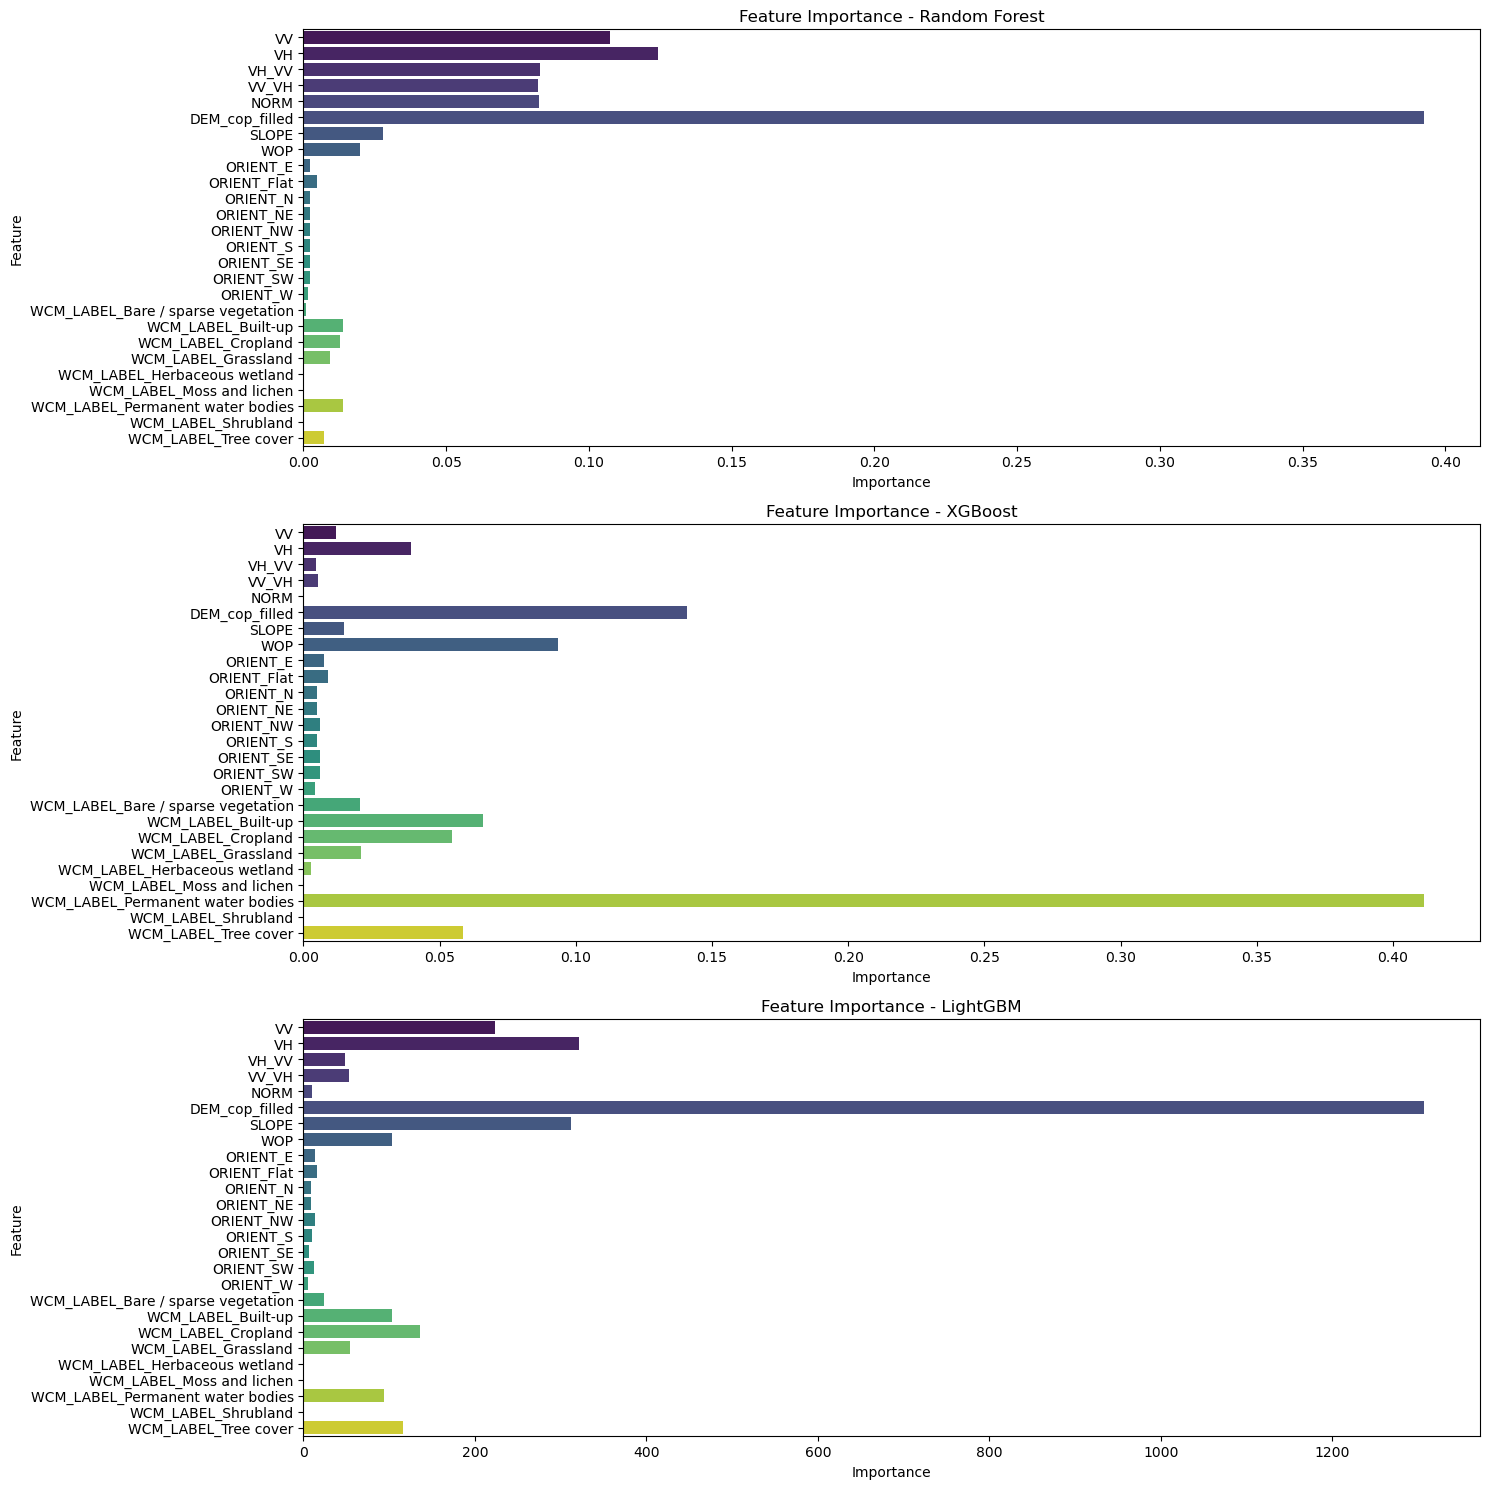

In [50]:
# Plot feature importance for each model
plt.figure(figsize=(15, 15))
for i, model in enumerate(feature_importance_df["Model"].unique()):
    plt.subplot(3, 1, i + 1)
    sns.barplot(data=feature_importance_df[feature_importance_df["Model"] == model], 
                x='Importance', y='Feature', palette='viridis')
    plt.title(f"Feature Importance - {model}")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
plt.tight_layout()
plt.show()


### 8.Boosting models optimization with optuna

Dado que se han seleccionado modelos boosting, la optimización se va a realizar con las features sin transformar

In [52]:
# X_train = X_train_bal[['VV','VH','VH_VV','VV_VH','NORM','DEM_cop','SLOPE','WCM','WOP']]
# X_train = X_train_bal[['VV','VH','VH_VV','VV_VH','NORM','DEM_mer','DEM_cop','SLOPE','ASPECT','WCM','WOP']]
X_train = X_train_bal
y_train = y_train_bal

print ('X_train and y_train shape:')
print(X_train.shape)
print(y_train.shape)

X_train and y_train shape:
(288044, 11)
(288044,)


In [70]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288044 entries, 0 to 288043
Data columns (total 11 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   VV       288044 non-null  float32
 1   VH       288044 non-null  float32
 2   VH_VV    288044 non-null  float32
 3   VV_VH    288044 non-null  float32
 4   NORM     288044 non-null  float32
 5   DEM_mer  288044 non-null  float32
 6   DEM_cop  288044 non-null  float32
 7   SLOPE    288044 non-null  float32
 8   ASPECT   288044 non-null  float32
 9   WCM      288044 non-null  float32
 10  WOP      288044 non-null  float32
dtypes: float32(11)
memory usage: 12.1 MB


#### 8.1 LGB

In [ ]:
def objective_lgb(trial):
    # 1. Suggest values for hyperparameters
    param = {
        'objective': 'binary',  # binary classification
        'metric': 'binary_logloss',
        'boosting_type': 'gbdt',
        'verbosity': -1,  # silent mode
        # 'is_unbalance': True,  # handles class imbalance

        # Tuneable hyperparameters
        'n_estimators': trial.suggest_int('n_estimators', 50, 200), 
        # 'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 200),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        # 'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        # 'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True)
    }

    # 2. Create the model
    model =LGBMClassifier(**param)

    # 3. Perform Stratified Cross-Validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(
        model,
        X_train,
        y_train,
        cv=cv,
        scoring=make_scorer(balanced_accuracy_score),
        n_jobs=-1
    )

    # 4. Return the mean balanced accuracy
    return score.mean()

In [36]:
study_lgb = optuna.create_study(direction='maximize')
study_lgb.optimize(objective_lgb, n_trials=50)  # You can try 100+ for deeper tuning

[I 2025-03-30 15:47:08,996] A new study created in memory with name: no-name-4d10f1ef-34ae-4bdf-8bf4-a7be4febce68
[I 2025-03-30 15:47:15,003] Trial 0 finished with value: 0.8287726588437675 and parameters: {'n_estimators': 84, 'num_leaves': 26, 'max_depth': 9, 'min_child_samples': 47, 'feature_fraction': 0.9704429336685036, 'bagging_fraction': 0.550041222213635, 'bagging_freq': 2}. Best is trial 0 with value: 0.8287726588437675.
[I 2025-03-30 15:47:21,775] Trial 1 finished with value: 0.8276061795020127 and parameters: {'n_estimators': 189, 'num_leaves': 163, 'max_depth': 4, 'min_child_samples': 100, 'feature_fraction': 0.7218239573980647, 'bagging_fraction': 0.7436922677158315, 'bagging_freq': 3}. Best is trial 0 with value: 0.8287726588437675.
[I 2025-03-30 15:47:32,554] Trial 2 finished with value: 0.8428538610654593 and parameters: {'n_estimators': 151, 'num_leaves': 84, 'max_depth': 8, 'min_child_samples': 15, 'feature_fraction': 0.7067771914426866, 'bagging_fraction': 0.708951896

In [37]:
print("Best trial:")
trial_lgb = study_lgb.best_trial
print(f"  Balanced Accuracy: {trial_lgb.value}")
print("  Best hyperparameters:")
for key, val in trial_lgb.params.items():
    print(f"    {key}: {val}")

Best trial:
  Balanced Accuracy: 0.8524044926786841
  Best hyperparameters:
    n_estimators: 185
    num_leaves: 197
    max_depth: 13
    min_child_samples: 50
    feature_fraction: 0.801604839479888
    bagging_fraction: 0.781848246305709
    bagging_freq: 7


#### 8.2 XGB

In [54]:
def objective_xgb(trial):
    # 1. Suggest hyperparameters
    param = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'use_label_encoder': False,
        'verbosity': 0,
        # 'scale_pos_weight': scale_pos_weight,  # helps with imbalance

        # Hyperparameters to tune
        # 'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        # 'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        # 'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 50, 200) 
    }

    # 2. Create the model
    model = XGBClassifier(**param)

    # 3. Cross-validation setup
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(
        model,
        X_train,
        y_train,
        cv=cv,
        scoring=make_scorer(balanced_accuracy_score),
        n_jobs=-1
    )

    # 4. Return average CV score
    return score.mean()


In [55]:
study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=50)  # Or more if time allows

[I 2025-03-30 16:33:45,420] A new study created in memory with name: no-name-33de448d-60f1-4a42-89d9-864826d4f27a
[I 2025-03-30 16:33:49,155] Trial 0 finished with value: 0.8276513186308648 and parameters: {'max_depth': 3, 'min_child_weight': 12, 'gamma': 4.096458189153372, 'subsample': 0.9488641285878479, 'colsample_bytree': 0.8433064449809684, 'n_estimators': 152}. Best is trial 0 with value: 0.8276513186308648.
[I 2025-03-30 16:33:58,021] Trial 1 finished with value: 0.8465755132323736 and parameters: {'max_depth': 13, 'min_child_weight': 3, 'gamma': 1.924659004018111, 'subsample': 0.5131425000558963, 'colsample_bytree': 0.903780881309346, 'n_estimators': 163}. Best is trial 1 with value: 0.8465755132323736.
[I 2025-03-30 16:34:00,654] Trial 2 finished with value: 0.8357368752256992 and parameters: {'max_depth': 8, 'min_child_weight': 20, 'gamma': 4.395450661708943, 'subsample': 0.9686250041820421, 'colsample_bytree': 0.6517684614606871, 'n_estimators': 72}. Best is trial 1 with val

In [56]:
print("Best trial:")
trial_xgb = study_xgb.best_trial

print(f"  Balanced Accuracy: {trial_xgb.value}")
print("  Best hyperparameters:")
for key, val in trial_xgb.params.items():
    print(f"    {key}: {val}")


Best trial:
  Balanced Accuracy: 0.854518734753059
  Best hyperparameters:
    max_depth: 10
    min_child_weight: 13
    gamma: 0.30183397472215895
    subsample: 0.9632107092478308
    colsample_bytree: 0.8714096744538734
    n_estimators: 199


#### 8.3 Boosting Best Model

In [57]:
best_params = study_xgb.best_trial.params

best_model = XGBClassifier(**best_params)
best_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8714096744538734, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.30183397472215895,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=13, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=199, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [58]:
# Save the model
model_filename = os.path.join(models_path, 'best_xgb_model.pkl')
joblib.dump(best_model, model_filename)

['c:\\Users\\maria\\Documents\\03_DS\\ML_SAR_floods\\src\\models\\best_xgb_model.pkl']

### 8. Model Evaluation

In [12]:
#Import best_model:
model_filename = os.path.join(models_path, 'best_xgb_model.pkl')
# Load the model
best_model = joblib.load(model_filename)

In [13]:
# Check X_test and y_test shape:

print ('X_test and y_test shape:')

print(X_test.shape)
print(y_test.shape)

X_test and y_test shape:
(836523, 11)
(836523,)


#### 8.1 Predictions

In [14]:
y_pred = best_model.predict(X_test)

#### 8.2 Evaluation metrics

Test Accuracy: 0.8583529681789981
Test Kappa: 0.2931275865995461

Classification Report :
              precision    recall  f1-score   support

     no_agua       0.99      0.86      0.92    800517
        agua       0.21      0.85      0.34     36006

    accuracy                           0.86    836523
   macro avg       0.60      0.86      0.63    836523
weighted avg       0.96      0.86      0.90    836523



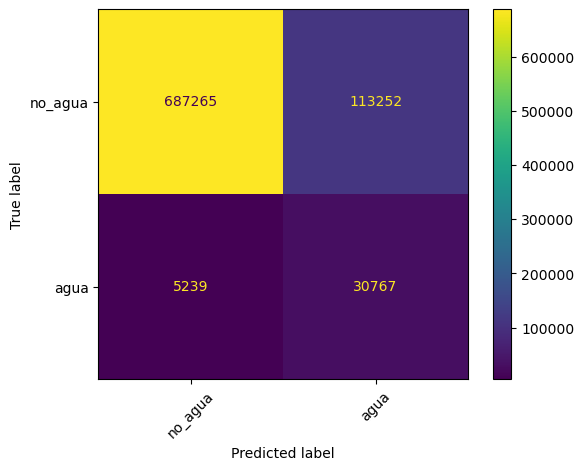

In [15]:
#Classification report
classes = ['no_agua','agua']
Kappa=cohen_kappa_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print(f"Test Accuracy: {accuracy}")
print(f"Test Kappa: {Kappa}")
print("\nClassification Report :")
print(classification_report(y_test, y_pred, target_names=classes))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
classes = ['no_agua','agua']

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes).plot();
plt.xticks(rotation=45)
plt.show()

#### 8.3 Post-training tunning decision threshold 

In [ ]:
# Get predicted probabilities
y_proba = best_model.predict_proba(X_test)[:, 1]

# Try lower thresholds
thresholds = np.linspace(0, 1, 100)
best_threshold = 0.5
best_f1 = 0

for t in thresholds:
    y_pred_thresh = (y_proba >= t).astype(int)
    f1 = f1_score(y_test, y_pred_thresh)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t

print(f"Best threshold for F1: {best_threshold:.2f} with F1: {best_f1:.2f}")

Best threshold for F1: 0.89 with F1: 0.54


In [17]:
# Use best threshold to generate final predictions
y_pred_final = (y_proba >= best_threshold).astype(int)

# Evaluate
print(f"Best threshold: {best_threshold:.2f}")
print(f"F1 Score at best threshold: {best_f1:.4f}")
print("Classification report:")
print(classification_report(y_test, y_pred_final, target_names=['No-Water', 'Water']))
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred_final))

Best threshold: 0.89
F1 Score at best threshold: 0.5448
Classification report:
              precision    recall  f1-score   support

    No-Water       0.98      0.98      0.98    800517
       Water       0.53      0.56      0.54     36006

    accuracy                           0.96    836523
   macro avg       0.75      0.77      0.76    836523
weighted avg       0.96      0.96      0.96    836523

Balanced Accuracy: 0.7699843812213645


#### 8.4 Model evaluation in a image

In [38]:
##Repetimos para una imagen
num_file = 29
img_df, label, row, col = dP.process_img(num_file)

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


In [39]:
img_proba = best_model.predict(img_df)

#Convertimos las probabilidades en 0 y 1
img_pred = [1 if i > .5 else 0 for i in img_proba]

# Reshape to 512x512 image and opening filtering, the flatten to evaluate
img_pred = np.reshape(img_pred,(row,col))
img_pred = binary_opening(img_pred)
img_pred = np.reshape(img_pred,(row*col))

# Metrics
Kappa=cohen_kappa_score(label, img_pred)
accuracy = accuracy_score(label, img_pred)

print(f"Test Accuracy: {accuracy}")
print(f"Test Kappa: {Kappa}")
print("\nClassification Report :")
print(classification_report(label, img_pred, target_names=classes))


Test Accuracy: 0.8691444396972656
Test Kappa: 0.16614023367154573

Classification Report :
              precision    recall  f1-score   support

     no_agua       1.00      0.87      0.93    257182
        agua       0.11      0.83      0.19      4962

    accuracy                           0.87    262144
   macro avg       0.55      0.85      0.56    262144
weighted avg       0.98      0.87      0.91    262144



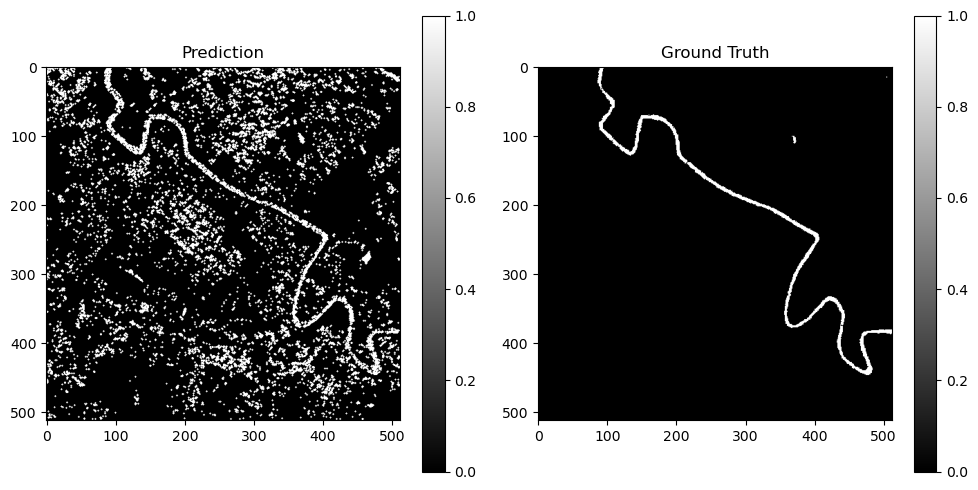

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


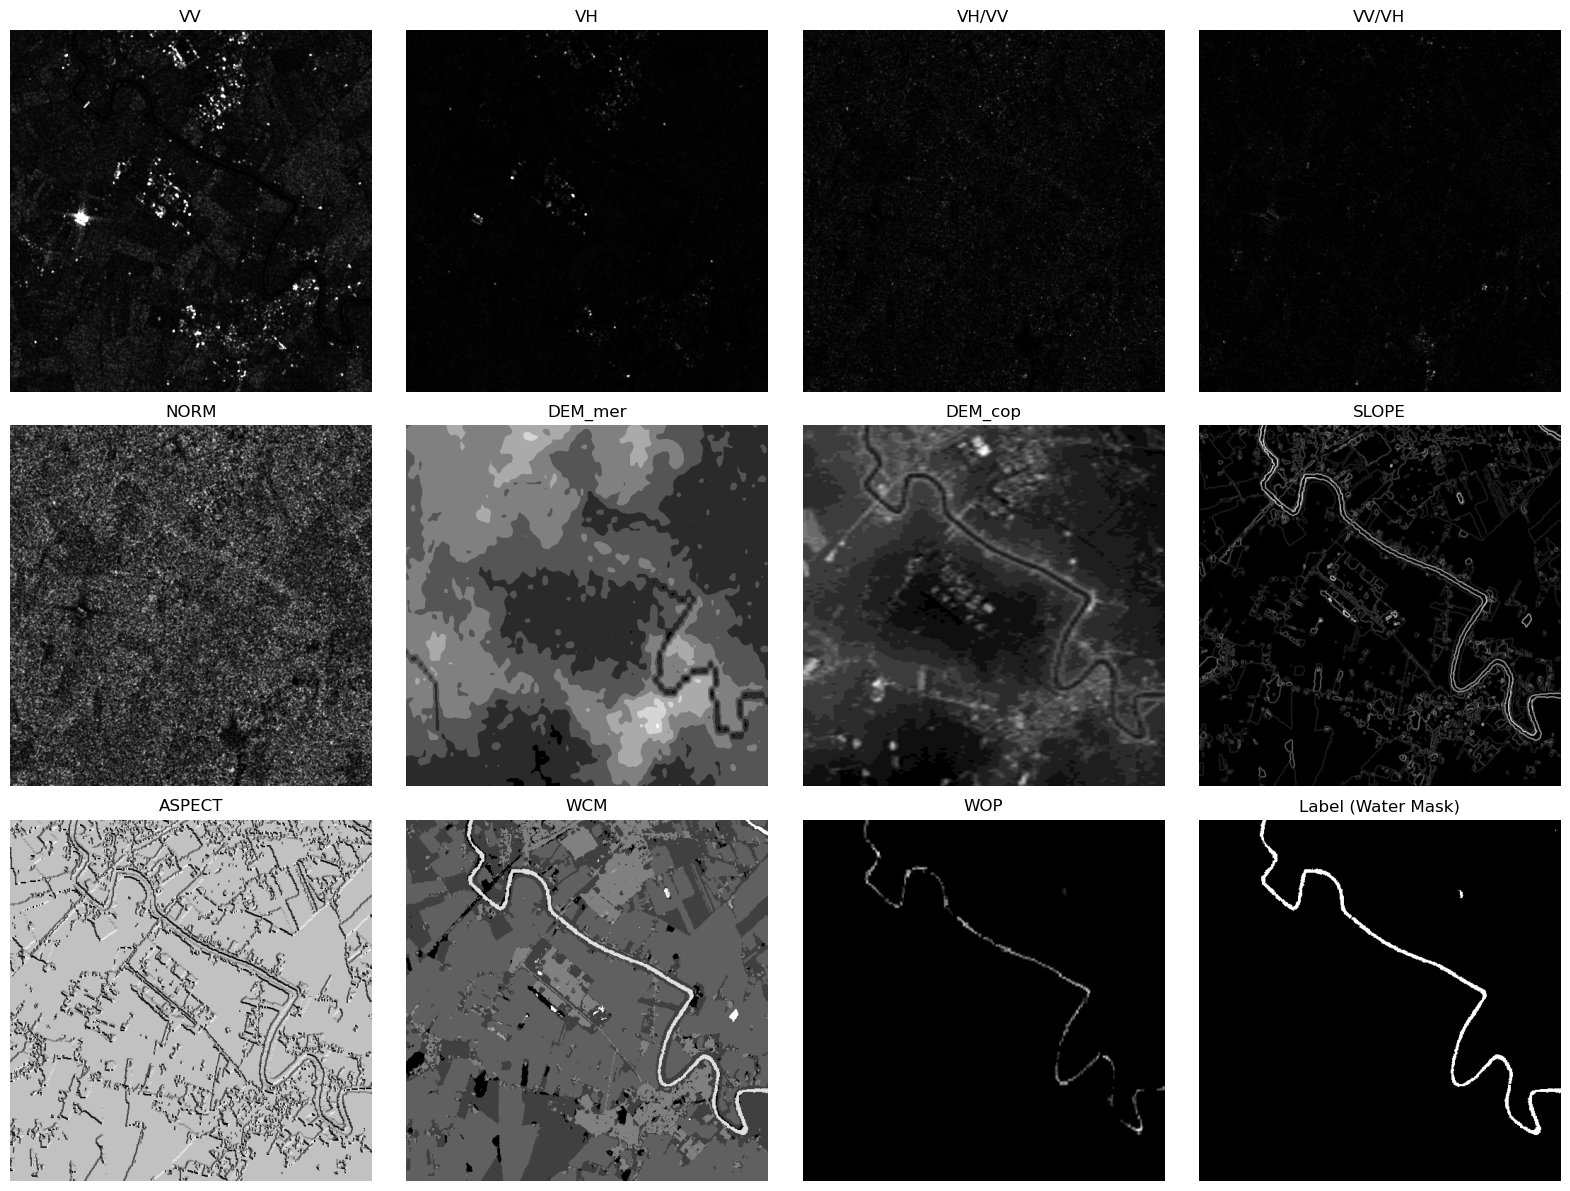

In [40]:
# Reshape to viz
img_pred = np.reshape(img_pred,(row,col))
label = np.reshape(label,(row,col))

# Create side-by-side plots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Prediction image
im1 = axs[0].imshow(img_pred, cmap='gray')
axs[0].set_title('Prediction')
fig.colorbar(im1, ax=axs[0])

# Ground truth label
im2 = axs[1].imshow(label, cmap='gray')
axs[1].set_title('Ground Truth')
fig.colorbar(im2, ax=axs[1])

# Show the plots
plt.tight_layout()
plt.show()

image_dir = 'C:/Users/maria/Documents/01_Teledeteccion/04_AEI/00_Practicas/Trabajo/Inputs/train/images'
label_dir = 'C:/Users/maria/Documents/01_Teledeteccion/04_AEI/00_Practicas/Trabajo/Inputs/train/labels' 
vz.visualize_features(num_file, image_dir,label_dir)